# 7506 - Trabajo práctico 1


##### Librerías

In [728]:
!pip install geopandas
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
import geopandas as gpd

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Defaulting to user installation because normal site-packages is not writeable


In [729]:
from IPython.display import display, HTML


def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [730]:
complete_dataset = pd.read_csv("./properati_argentina_2021.csv")
df = complete_dataset.copy()

## Análisis Exploratorio y Preprocesamiento de Datos

Primero, observaremos un poco los datos que tiene el dataset

**Primeras 5 observaciones**

In [731]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


**Ultimas 5 observaciones**

In [732]:
df.tail()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
460149,EWHC/xcODFkeEA0+pPE6Rw==,2021-01-05,2021-01-08,2021-01-05,-34.599594,-58.588715,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,NaN,NaN,NaN,Venta,Local comercial,NaN,NaN,113.0,113.0,190000.0,USD,LOCAL COMERCIAL MAS DE 100 MTS. - Ciudad jardín-
460150,txKUq0LjMaORjJQeeqTOfw==,2021-01-05,2021-11-01,2021-01-05,-34.582777,-58.545220,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Lynch,NaN,NaN,Venta,Local comercial,NaN,NaN,11580.0,11580.0,3500000.0,USD,Nave Industrial - Villa Lynch
460151,E0zwHT18DX8AxhU22hXgng==,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,Venta,Local comercial,NaN,NaN,915.0,915.0,800000.0,USD,importante edificio comercial en tres plantas ...
460152,Ec4Tvy/WX5f6RgfaJf2FHQ==,2021-01-05,2021-11-28,2021-01-05,-33.226234,-60.331848,Santa Fe,Villa Constitución,NaN,NaN,NaN,Alquiler,Local comercial,NaN,NaN,NaN,15.0,NaN,NaN,Local - Villa Constitucion
460153,Y7KBafQ+e5noGh2Pio0xLg==,2021-01-05,9999-12-31,2021-01-05,-26.827938,-65.220708,Tucumán,San Miguel de Tucumán,NaN,NaN,NaN,Venta,Local comercial,1.0,NaN,243.0,133.0,160000.0,USD,Local - San Miguel De Tucumán


In [733]:
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 460154 filas y 20 columnas


In [734]:
df.describe()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,419740.000000,419740.000000,0.0,368498.000000,344113.000000,397813.000000,4.279160e+05,4.421530e+05
mean,-34.228570,-59.557066,NaN,3.278053,2.297960,420.601250,9.605005e+03,3.063273e+05
std,3.251509,2.905129,NaN,1.870832,1.673985,4026.380748,3.440367e+06,4.899613e+06
min,-54.832057,-103.219258,NaN,1.000000,-3.000000,-1.000000,-3.000000e+00,0.000000e+00
25%,-34.640132,-58.899343,NaN,2.000000,1.000000,50.000000,4.500000e+01,4.490000e+04
50%,-34.585122,-58.488309,NaN,3.000000,2.000000,90.000000,7.800000e+01,9.800000e+04
75%,-34.423414,-58.404876,NaN,4.000000,3.000000,210.000000,1.700000e+02,1.990000e+05
max,42.557773,-35.044991,NaN,40.000000,390.000000,200000.000000,2.147484e+09,1.500000e+09


In [735]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [736]:
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

## Descripción de las columnas
- type - Tipo de aviso (Propiedad, Desarrollo/Proyecto).
- country - País en el que está publicado el aviso (Argentina, Uruguay, Colombia, Ecuador, Perú)
- id - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.
- start_date - Fecha de alta del aviso.
- end_date - Fecha de baja del aviso.
- created_on - Fecha de alta de la primera versión del aviso.
- place - Campos referidos a la ubicación de la propiedad o del desarrollo.

   - lat - Latitud.

   - lon - Longitud.

   - l1 - Nivel administrativo 1: país.

   - l2 - Nivel administrativo 2: usualmente provincia.

   - l3 - Nivel administrativo 3: usualmente ciudad.

   - l4 - Nivel administrativo 4: usualmente barrio.
- property - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto).

   - operation - Tipo de operación (Venta, Alquiler).

   - type - Tipo de propiedad (Casa, Departamento, PH).

   - rooms - Cantidad de ambientes (útil en Argentina).

   - bedrooms - Cantidad de dormitorios (útil en el resto de los países).

   - bathrooms - Cantidad de baños.

   - surface_total - Superficie total en m².

   - surface_covered - Superficie cubierta en m².

   - price - Precio publicado en el anuncio.

   - currency - Moneda del precio publicado.

   - price_period - Periodo del precio (Diario, Semanal, Mensual)

   - title - Título del anuncio.

   - description - Descripción del anuncio.
- development - Campos relativos al desarrollo inmobiliario (vacío si el aviso es de una propiedad).
- status - Estado del desarrollo (Terminado, En construcción, ...)
- name - Nombre del desarrollo.
- short_description - Descripción corta del anuncio.
- description - Descripción del anuncio.


## Filtrado inicial del Dataset
Como trabajaremos con un universo acotado de propiedades, haremos una selección inicial de las publicaciones que nos interesa analizar:

Como primer paso hay que filtrar las observaciones que su tipo de vivienda sea: Casa, PH o Departamento.

Luego filtramos la ubicacion quedandonos unicamente con las propiedades de Capital Federal.

A continuación, consideraremos solo las que esten cotizadas en dolares.

Y finalmente, tomamos solo las que sean ventas

In [737]:
df_tipo_vivienda = df[(df.property_type == "Casa") | (df.property_type == "PH") | (df.property_type == "Departamento")]
df_por_ubicacion = df_tipo_vivienda[
    (df_tipo_vivienda.place_l2 == "Capital Federal") | (df_tipo_vivienda.place_l3 == "Capital Federal")]
df_cotizacion_usd = df_por_ubicacion[df_por_ubicacion.property_currency == "USD"]
ds_filtrado = df_cotizacion_usd[df_cotizacion_usd.operation == "Venta"]

ds_filtrado[["place_l2", "place_l3", "property_currency", "property_type", "operation"]]

,place_l2,place_l3,property_currency,property_type,operation
25,Capital Federal,NaN,USD,Casa,Venta
42,Capital Federal,Boca,USD,Departamento,Venta
43,Capital Federal,Boca,USD,Departamento,Venta
49,Capital Federal,Once,USD,Departamento,Venta
51,Capital Federal,Boedo,USD,PH,Venta
...,...,...,...,...,...
460072,Capital Federal,Villa del Parque,USD,Departamento,Venta
460073,Capital Federal,Villa del Parque,USD,Departamento,Venta
460074,Capital Federal,Villa del Parque,USD,Departamento,Venta
460075,Capital Federal,Villa del Parque,USD,Departamento,Venta


A partir de aquí trabajaremos con el dataset filtrado (`ds_filtrado`)

Analizando los tipos de dato de los campos:
- Hay 3 campos de fecha, evaluaremos más adelante como tratarlos.
- Tenemos latitud y longitd en su formato correcto
- Hay una variable place_l6 que no debería ser un número, también analizaremos a que se debe.
- La cantidad de habitaciones (rooms y bedrooms) quizás debería tener valores enteros.
- El precio tiene un tipo correcto

## Exploración Inicial

### Tipos de variable

In [738]:
categoricas = ['created_on','start_date', 'end_date', 'place_l2', 'place_l3', 'place_l4', 'place_l5', 'place_l6', 'operation', 'property_type', 'property_currency', 'property_title']
cuantitativas_discretas = ['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', None, None, None, None, None, None, None, None]
cuantitativas_continuas = ['latitud', 'longitud','property_price', None, None, None, None, None, None, None, None, None]
ordinales = [None, None, None, None, None, None, None, None, None, None, None, None]
tipos_de_variable = {'Categoricas': categoricas, 'Ordinales': ordinales, 'Cuantitativas Discretas': cuantitativas_discretas, 'Cuantitativas Continuas': cuantitativas_discretas}

cuantitativas = cuantitativas_discretas + cuantitativas_continuas

pd.DataFrame(tipos_de_variable)

,Categoricas,Ordinales,Cuantitativas Discretas,Cuantitativas Continuas
0,created_on,None,property_rooms,property_rooms
1,start_date,None,property_bedrooms,property_bedrooms
2,end_date,None,property_surface_total,property_surface_total
3,place_l2,None,property_surface_covered,property_surface_covered
4,place_l3,None,None,None
5,place_l4,None,None,None
6,place_l5,None,None,None
7,place_l6,None,None,None
8,operation,None,None,None
9,property_type,None,None,None


### Fechas


In [739]:
ds_filtrado[["start_date", "end_date", "created_on"]].isna().sum()

start_date    0
end_date      0
created_on    0
dtype: int64

In [740]:
ds_filtrado["start_date"].value_counts()

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: start_date, Length: 365, dtype: int64

In [741]:
ds_filtrado["end_date"].value_counts()

2021-06-05    12817
2022-01-27     9287
2022-02-09     7633
9999-12-31     5041
2021-03-01     1857
              ...  
2022-08-26        1
2022-08-16        1
2022-06-14        1
2022-08-22        1
2022-03-22        1
Name: end_date, Length: 607, dtype: int64

In [742]:
ds_filtrado[ds_filtrado.created_on != ds_filtrado.start_date].shape

(0, 20)

Podemos ver que la columnas created_on y start_date siempre son iguales, descartaremos una de ellas más adelante.

In [743]:
ds_filtrado["created_on"].value_counts()

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: created_on, Length: 365, dtype: int64

Hay un valor extraño en end_date, la fecha 9999-12-31, hay 5041 apariciones de esta fecha

In [744]:
ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date'].value_counts()

2021-02-09    132
2021-06-24    122
2021-06-30     79
2021-02-23     74
2021-07-21     67
             ... 
2021-12-27      1
2021-11-29      1
2021-03-09      1
2021-05-10      1
2021-04-02      1
Name: start_date, Length: 296, dtype: int64

Considerando que todas las fechas son de 2021, y que el dato que falta es el del fin de la publicación (es decir, la casa esta publicada) y a fines de preservar estos datos, traeremos a consideración la duración promedio de cada publicación, calcularemos ese promedio dejando fuera los 5041 casos que presentan la fecha inválida.

Tomaremos para el cálculo las fechas convertidas a datetime.

In [745]:
dias = pd.to_datetime(ds_filtrado[ds_filtrado.end_date != '9999-12-31']['end_date']) - pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date != '9999-12-31']['start_date'])
dias.describe()

count                         89208
mean     74 days 10:42:07.845036320
std      84 days 04:14:04.193191497
min                 0 days 00:00:00
25%                16 days 00:00:00
50%                51 days 00:00:00
75%                99 days 00:00:00
max               618 days 00:00:00
dtype: object

El promedio de la duración de las publicaciones es casi de 75 días, asumiremos que las publicaciones con la fecha invalida duraron lo mismo que el promedio y tomaremos como fecha final la fecha de inicio + 75 días.

In [746]:
ds_filtrado.loc[ds_filtrado.end_date == '9999-12-31', 'end_date'] = pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date']) + dias.mean()
ds_filtrado.end_date

25        2021-09-26
42        2021-09-26
43        2021-09-28
49        2022-01-05
51        2022-03-09
             ...    
460072    2022-09-02
460073    2021-02-17
460074    2021-01-27
460075    2021-01-27
460090    2021-01-08
Name: end_date, Length: 94249, dtype: object

Finalmente, como todos los valores son formatos válidos de fecha, podemos convertir sin problemas.

### Conversion tipo de dato

In [747]:
new_ds = ds_filtrado.copy()
new_ds.start_date = pd.to_datetime(new_ds.start_date, infer_datetime_format=True)
new_ds.end_date = pd.to_datetime(new_ds.end_date, infer_datetime_format=True)
new_ds.created_on = pd.to_datetime(new_ds.created_on, infer_datetime_format=True)
ds_filtrado = new_ds.copy()
ds_filtrado.dtypes

id                                  object
start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
place_l2                            object
place_l3                            object
place_l4                            object
place_l5                            object
place_l6                           float64
operation                           object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
property_price                     float64
property_currency                   object
property_title                      object
dtype: object

## Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda

In [748]:
# Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda
cuantitativas_filtradas = list(filter(lambda element: element != None, cuantitativas))
description_quantitatives = ds_filtrado[cuantitativas_filtradas].describe()

quantitative_mode = ds_filtrado[cuantitativas_filtradas].mode()
quantitative_mode.rename(index={0: "mode"}, inplace=True)
description_quantitatives = description_quantitatives.append(quantitative_mode)

description_quantitatives.rename(index={"25%":"quartile 1","50%":"median","75%":"quartile 3"}, inplace=True)
description_quantitatives

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud,property_price
count,93205.000000,83262.000000,89405.000000,90895.000000,90519.000000,90519.000000,9.424900e+04
mean,2.822799,2.014629,109.092970,87.931932,-34.591481,-58.449795,2.262382e+05
std,1.426148,1.129767,980.401976,990.927129,0.181719,0.292630,3.186035e+05
min,1.000000,-1.000000,10.000000,1.000000,-53.788624,-71.471192,5.000000e+03
quartile 1,2.000000,1.000000,45.000000,40.000000,-34.615975,-58.466522,9.500000e+04
median,3.000000,2.000000,65.000000,58.000000,-34.595790,-58.439000,1.439000e+05
quartile 3,4.000000,3.000000,105.000000,88.000000,-34.577413,-58.408862,2.370000e+05
max,40.000000,70.000000,137000.000000,217000.000000,-24.219827,-54.133330,2.140000e+07
mode,3.000000,1.000000,50.000000,40.000000,-34.541250,-58.472966,1.100000e+05


## Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [749]:
qualitative_dataset = ds_filtrado[categoricas]

dfs = list(
    pd.DataFrame(qualitative_dataset[column].value_counts().head()) for column in qualitative_dataset.columns.tolist())
display_side_by_side(dfs, qualitative_dataset.columns.tolist())

,created_on
2021-12-16 00:00:00,4674
2021-02-13 00:00:00,2121
2021-11-03 00:00:00,1016
2021-08-03 00:00:00,836
2021-04-10 00:00:00,819
,start_date
2021-12-16 00:00:00,4674
2021-02-13 00:00:00,2121
2021-11-03 00:00:00,1016
2021-08-03 00:00:00,836


La tabla muestra varias cosas:
- Hay 94249 propiedades habiendo filtrado solo las de Capital Federal, Venta y USD
- Hay 80829 departamentos, 9266 PHs y 4154 casas
- Hay 14308 propiedades en Palermo
- El id de la propiedad es único y no representa nada útil para nuestro procesamiento. Parecería pasar algo similar con el título, lo analizaremos en más detalle más adelante

## Análisis gráfico de las distribuciones de las variables

#### Distribución de fechas 

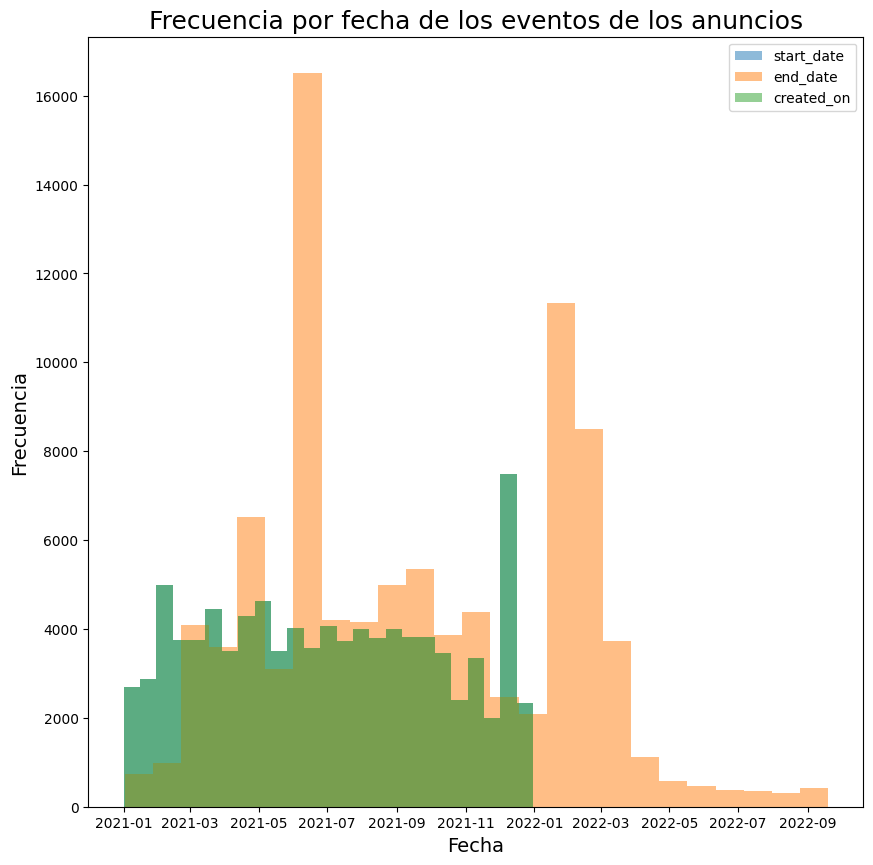

In [750]:

plt.figure(figsize=(10,10))
plt.hist(ds_filtrado.start_date, bins=25, alpha=0.5, label="start_date")
plt.hist(ds_filtrado.end_date, bins=25, alpha=0.5, label="end_date")
plt.hist(ds_filtrado.created_on, bins=25, alpha=0.5, label="created_on")
plt.xlabel("Fecha", size=14)
plt.ylabel("Frecuencia", size=14)
plt.title("Frecuencia por fecha de los eventos de los anuncios",size=18)
plt.legend(loc='upper right')


En este grafico se puede apreciar la distribución de las variables que hacen referencia a las fechas de creacion, alta y baja de los anuncios. Podemos ver que la distribución de las fechas de creación coincide con la distribución de las fechas de alta del anuncio, lo cual tiene sentido que así sea ya que la fecha de creación del anuncio es la primer versión del anuncio en ser dada de alta. 

###  Distribución de barrios
Primero vemos la cantidad de apariciones de los barrios por anuncio en la siguiente tabla:

In [751]:
ds_filtrado['place_l3'].value_counts()

Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          639
Villa Luga

Como podemos observar, hay demasiados barrios con pocas apariciones, por lo que nos centraremos en visualizar los primeras 10 barrios que mas aparecen. Agrupando al resto en una nueva categoria llamada "Otras".

In [752]:
top10 = ds_filtrado['place_l3'].value_counts().head(10)

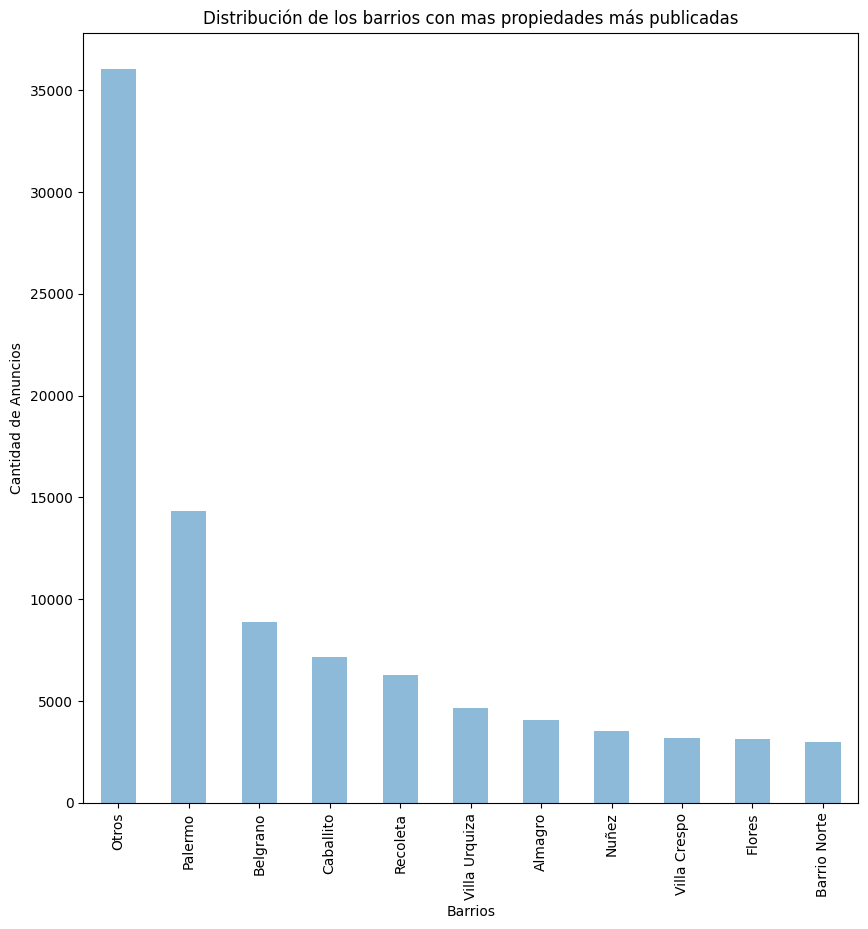

In [753]:
ds_otros_barrios = ds_filtrado[~ds_filtrado['place_l3'].isin(top10.index)] # tomamos solo con las observaciones que no pertenecen al top 10 de barrios
frecuencia_otras = ds_otros_barrios.shape[0] 
otras = pd.Series(data=[frecuencia_otras], index=["Otros"])
distribucion_por_barrios = pd.concat([otras,top10])

ax = distribucion_por_barrios.plot.bar(alpha=0.5 , title="Distribución de los barrios con mas propiedades más publicadas" , xlabel="Barrios" , ylabel="Cantidad de Anuncios",figsize=(10, 10))

El barrio de Palermo es la que tiene mas propiedades publicadas

### Distribución de tipos de propiedad

Para analizar la distribucion de la variable property_type vamos a agrupar las apariciones en un grafico de barras por tipo de propiedad

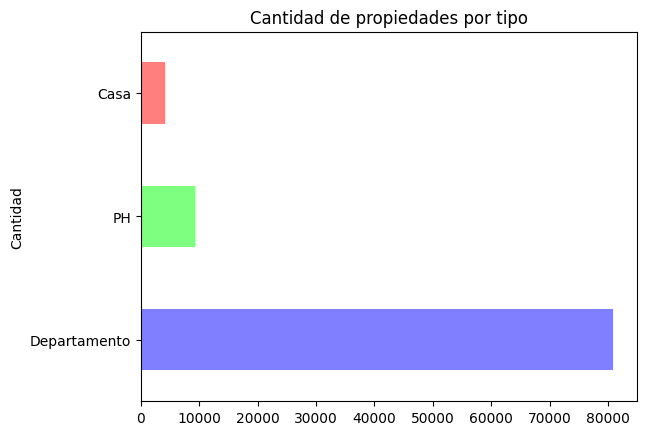

In [754]:
colores=[(0,0,1),(0,1,0),(1,0,0)]
grf=ds_filtrado['property_type'].value_counts().plot.barh(alpha=0.5,color=colores, title="Cantidad de propiedades por tipo",ylabel="Cantidad")  

A simple vista se puede ver que la mayoria de publicaciones son de departamentos por una amplia diferencia

### Distribución de latitud y longitud
Para analizar la longitud y latitud vamos a utilizar un grafico de a pares ya que nos aporta más información sobre su distribución, pudiendo visualizar la localización de la propiedad. Adicionalmente se distinguirá por el tipo de propiedad.

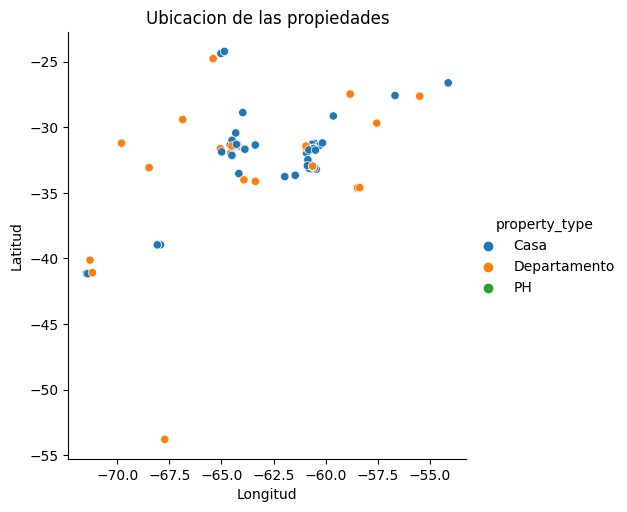

In [755]:
#grf=ds_filtrado.plot.scatter(x="latitud", y="longitud", s=10).set(title="Distribucion de observaciones por latitud y longitud",xlabel='Age',ylabel='Fare') 
sns.relplot(data=ds_filtrado,x="longitud", y="latitud", hue="property_type").set(title="Ubicacion de las propiedades",xlabel='Longitud',ylabel='Latitud')

Podemos ver que la mayoria de propiedades publicadas se encuentran concentradas en un área en particular, donde mayormente son de tipo Casa. Y al alejarse se ven departamentos distanciados entre sí.

### Distribución de habitaciones y baños

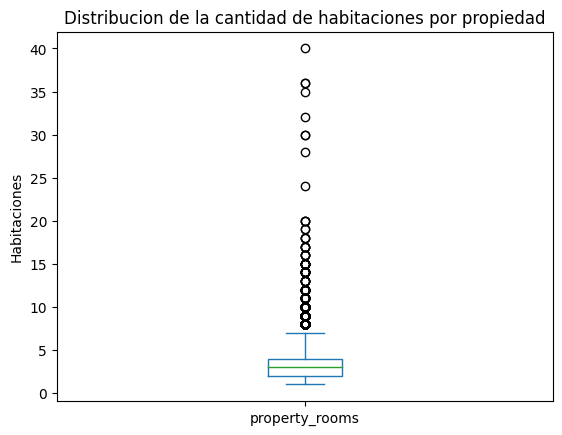

In [756]:
grf=ds_filtrado.property_rooms.plot.box(title="Distribucion de la cantidad de habitaciones por propiedad",ylabel="Habitaciones")

Podemos ver que hay una gran cantidad de outliers, siendo 40 el que mas se aleja, para visualizar mejor la distribucion del boxplot veremos un nuevo grafico sin considerar los outliers.

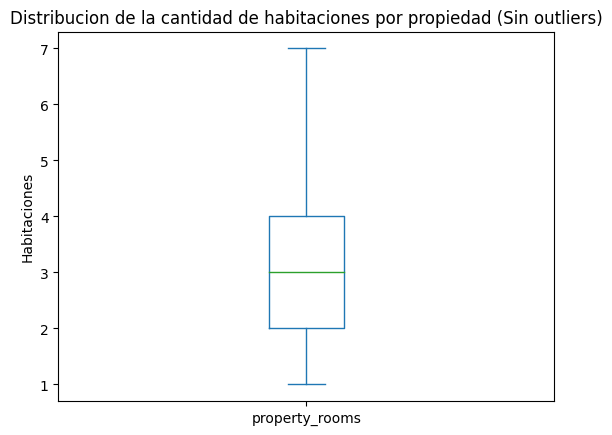

In [757]:
q1 = ds_filtrado.property_rooms.quantile(q=0.25)
q3 = ds_filtrado.property_rooms.quantile(q=0.75)
iqr = q3 - q1
max = q3 + (iqr * 1.5)

property_rooms_filtrado = ds_filtrado[ds_filtrado.property_rooms <= max].property_rooms
grf=property_rooms_filtrado.plot.box(title="Distribucion de la cantidad de habitaciones por propiedad (Sin outliers)",ylabel="Habitaciones")

Ahora si podemos visualizar mejor los valores de la mediana, q3, q1 y los bigotes. Que toman la siguiente cantidad de habitaciones:

*   Bigotes: 1 y 7.
*   Cuartil 1: 2
*   Mediana: 3.
*   Cuartil 3: 4.





Hacemos el mismo procedimiento ver la distribución de la cantidad de baños por propiedad

<AxesSubplot: title={'center': 'Distribucion de la cantidad de baños por propiedad'}, ylabel='Baños'>

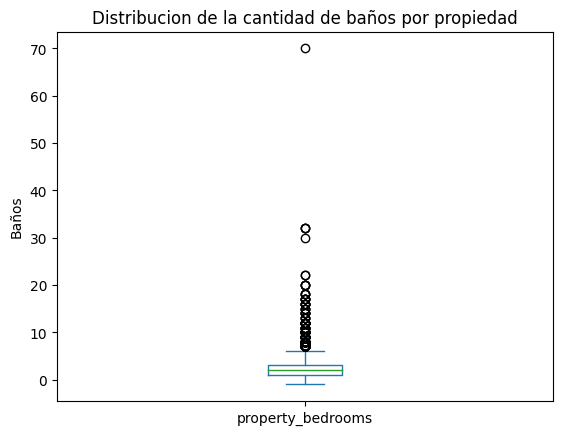

In [758]:
ds_filtrado.property_bedrooms.plot.box(title="Distribucion de la cantidad de baños por propiedad",ylabel="Baños")

Vemos que esta vez hay mas distancia entre el outlier mas alejado y el resto de outliers.

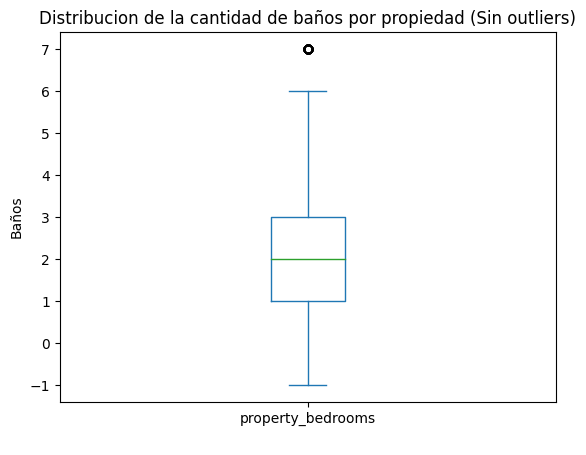

In [759]:
q1 = ds_filtrado.property_rooms.quantile(q=0.25)
q3 = ds_filtrado.property_rooms.quantile(q=0.75)
iqr = q3 - q1
max = q3 + (iqr * 1.5)

property_bedrooms_filtrado = ds_filtrado[ds_filtrado.property_bedrooms <= max].property_bedrooms
grf=property_bedrooms_filtrado.plot.box(title="Distribucion de la cantidad de baños por propiedad (Sin outliers)",xlabel=" ",ylabel="Baños")

En este caso toman los siguientes valores:

*   Bigotes: -1 y 6.
*   Cuartil 1: 1.
*   Mediana: 2.
*   Cuartil 3: 3.


### Distribución de precio

Para analizar la distribución del precio, como es un tipo de variable continua y cada observación puede tomar un valor en un rango muy grande, optamos por hacer una agrupación por rangos de precios, obteniendo una categoria por cada rango.
Vamos a considerar la mediana para establecer los limites entre cada grupo, consideramos que es un buen valor para dividir al conjunto en partes ya que no se ve afectado drasticamente por outliers (como si sucede con la media).

In [760]:
print(f"La mediana del precio es: {ds_filtrado.property_price.median()}")

La mediana del precio es: 143900.0


<AxesSubplot: title={'center': 'Distribucion de los precios de las propiedades'}, xlabel='Rango de precios', ylabel='Frecuencia'>

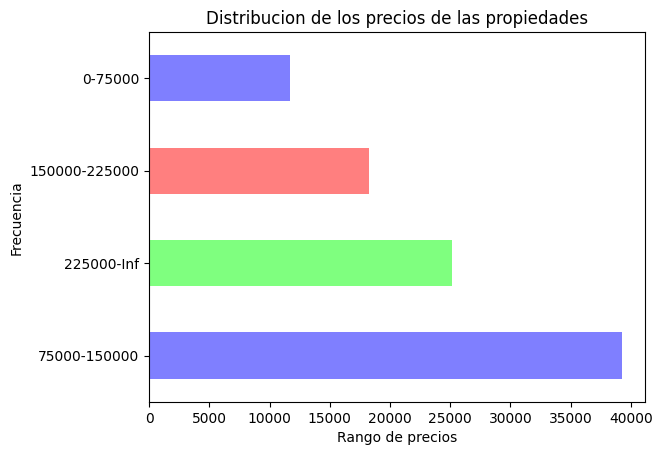

In [761]:
# Tomamos valores alrededor de la mediana
property_price_grouped = pd.cut(ds_filtrado.property_price,bins=[0,75000,150000,225000,float("inf")],labels=["0-75000","75000-150000","150000-225000","225000-Inf"],include_lowest=True)
property_price_grouped.value_counts().plot.barh(alpha=0.5,color=colores, title="Distribucion de los precios de las propiedades", xlabel="Rango de precios",ylabel="Frecuencia")

Podemos ver que la mayoria de propiedades estan dentro del rango de 75000 y 150000 USD.

### Distribución de superficie total y cubierta

Utilizaremos un violin plot para cada variable. 

In [762]:
#sns.violinplot(ds_filtrado.property_surface_total)

A simple vista no esta muy claro el gráfico por la cantidad de outliers que hay, por lo que dejaremos de lado la mayoria de outliers para interpretarlo mas en detalle.

In [763]:
ds_surface_sin_outliers =  ds_filtrado[ds_filtrado.property_surface_total < 600]
#sns.violinplot(ds_surface_sin_outliers.property_surface_total)

Podemos ver que entre 0 y 100 se encuentra la mayor densidad

Hacemos el mismo procedimiento para visualizar la distribución de la superficie cubierta de la propiedad

In [764]:
ds_surface_covered_sin_outliers =  ds_filtrado[ds_filtrado.property_surface_covered < 600]
#sns.violinplot(ds_surface_covered_sin_outliers.property_surface_covered)

Se nota que el grafico de property_surface_total es similar al de property_surface_covered, teniendo el segundo una densidad levemente menor. 

## Correlación entre variables

A continuación analizaremos la correlación entre las variables cuantitativas, primero visualizando la distribución a pares entre estas.

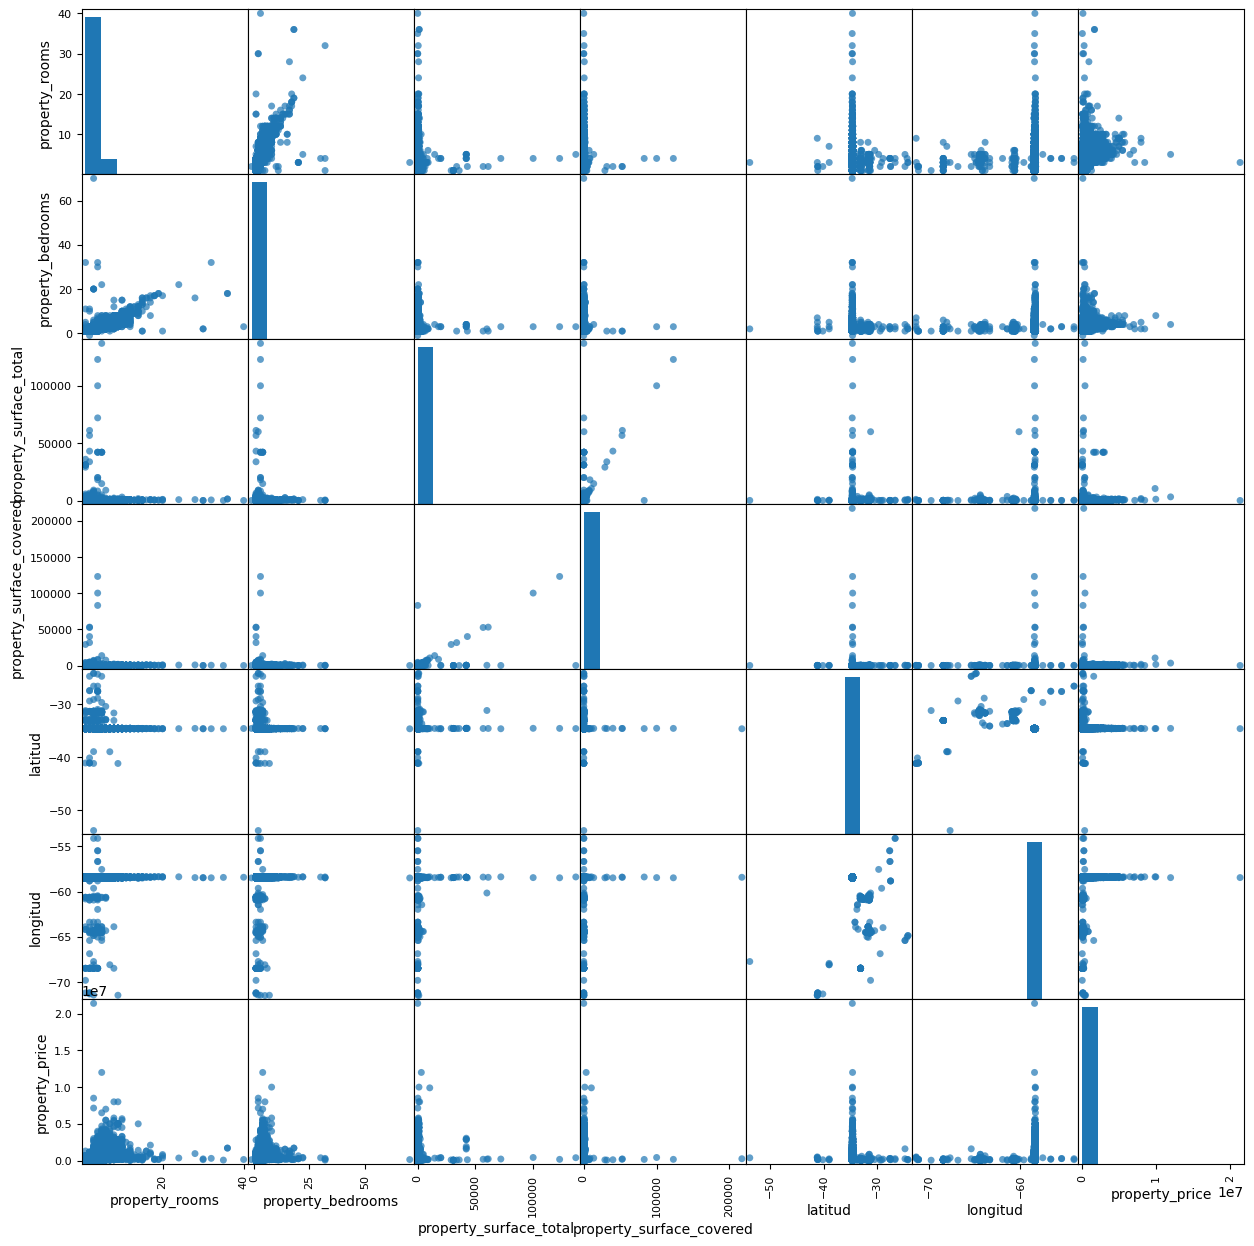

In [765]:
quantitative_dataset = ds_filtrado[cuantitativas_filtradas]
ax = scatter_matrix(quantitative_dataset, alpha=0.7,figsize=(15, 15), s=100)

Si bien a simple vista no esta muy claro que variables están correlacionadas entre sí, podemos suponer que puede llegar a haber relación entre property_rooms y property_bedrooms, property_surface_total y property_surface_covered, property_price y property_rooms, property_price y property_bedrooms. Las cuales tiene sentido que pudiesen tener algún tipo de relación.

Además podemos considerar en menor medida que haya una relación entre longitud y latitud (cosa que no necesariamente tendría que ser así)




Analizaremos la correlación lineal entre variables por medio de la medición del coeficiente de Pearson

In [766]:
correlations = quantitative_dataset.corr()
correlations

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud,property_price
property_rooms,1.000000,0.871940,0.067211,0.076097,0.005521,-0.008324,0.488934
property_bedrooms,0.871940,1.000000,0.067702,0.075075,0.003162,-0.008556,0.425386
property_surface_total,0.067211,0.067702,1.000000,0.604311,0.025348,-0.015056,0.085235
property_surface_covered,0.076097,0.075075,0.604311,1.000000,0.002352,-0.001155,0.056238
latitud,0.005521,0.003162,0.025348,0.002352,1.000000,-0.239235,0.016635
longitud,-0.008324,-0.008556,-0.015056,-0.001155,-0.239235,1.000000,0.023314
property_price,0.488934,0.425386,0.085235,0.056238,0.016635,0.023314,1.000000


Haremos un heatmap que nos permite visualizar mejor la correlación

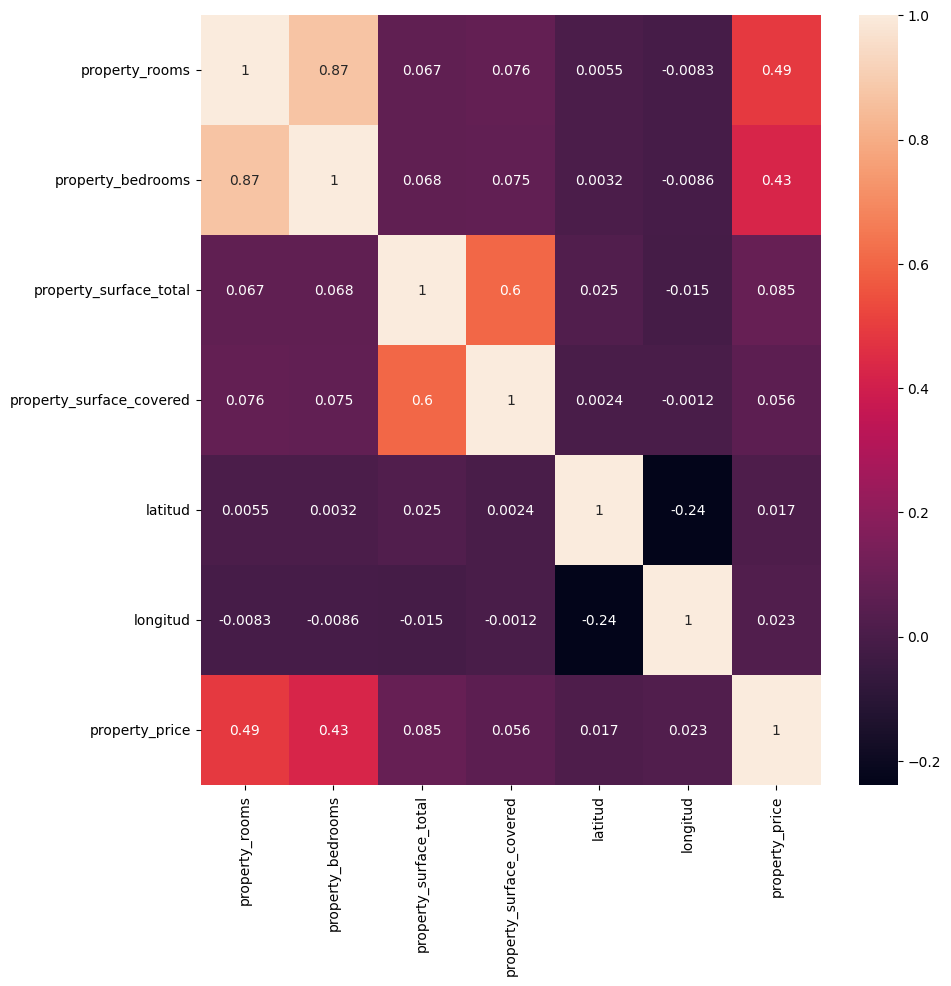

In [767]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(quantitative_dataset.corr(), annot=True)

Luego de calcular el coeficiente de Pearson donde los que resultan cercanos a 1 indican una gran correlación entre sí, los que tienden a 0 tienen poca correlación y los cercanos a -1 presentan una notable correlación negativa.

Veremos si las variables que parecían relacionarse anteriormente realmente lo hacen:


In [768]:
posible_correlations = [('property_rooms','property_bedrooms'),('property_price','property_bedrooms'),('property_price','property_rooms'),('property_surface_total','property_surface_covered'),('longitud','latitud')]
for corr in posible_correlations:
  print(f"Entre {corr[0]} y {corr[1]}:{round(correlations.loc[corr[0],corr[1]],2)}")

Entre property_rooms y property_bedrooms:0.87
Entre property_price y property_bedrooms:0.43
Entre property_price y property_rooms:0.49
Entre property_surface_total y property_surface_covered:0.6
Entre longitud y latitud:-0.24


Podemos sacar las siguientes conclusiones sobre las variables que parecian relacionarse:


*   Hay mucha relación entre la cantidad de habitaciones y ambientes.
*   Hay menos relación entre la superficie total y superficie cubierta de la propiedad.
*   Casi no hay relación entre el precio y la cantidad de habitaciones.
*   Casi no hay relación entre el precio y la cantidad de ambientes.
*   No hay relación entre la latitud y la longitud.





## Análisis de valores faltantes

Ahora analizaremos los datos faltantes del dataset.

### Porcentaje de valores faltantes por columna



id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


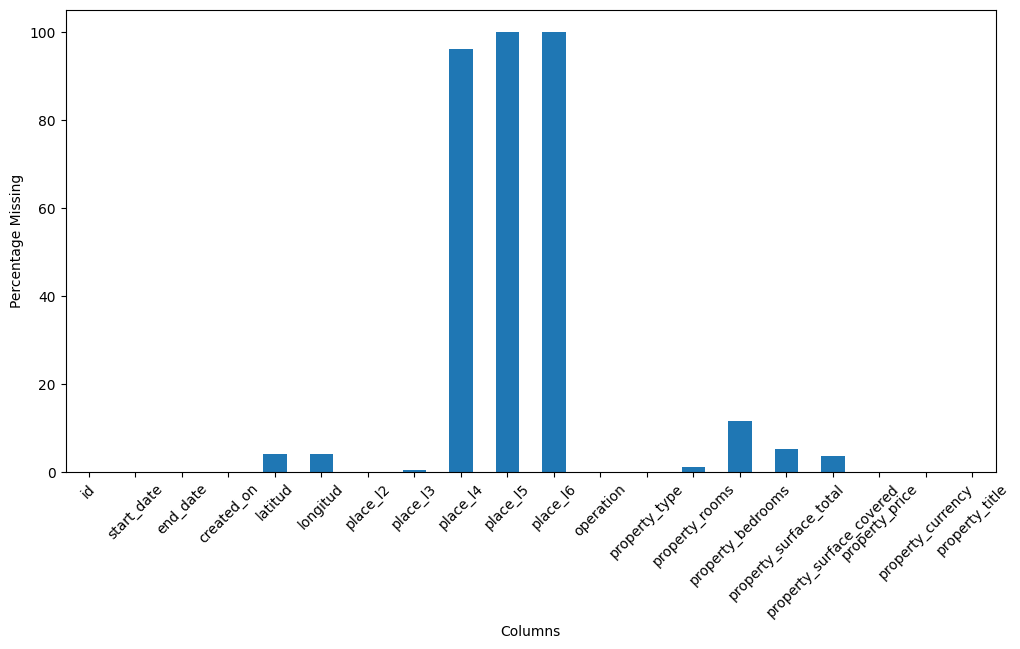

In [769]:
percent_missing = ds_filtrado.isna().sum() * 100 / len(ds_filtrado)
plt.figure(figsize=(12, 6))
percent_missing.plot.bar(x='index', rot=45)
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
rows = ds_filtrado.shape[0]
print(ds_filtrado.isna().sum() / rows * 100)

A simple vista podemos ver que las columnas place_l4,place_l5 y place_l6 practicamente no tienen datos, procederemos a eliminarlas.

### Porcentaje de datos faltantes por fila

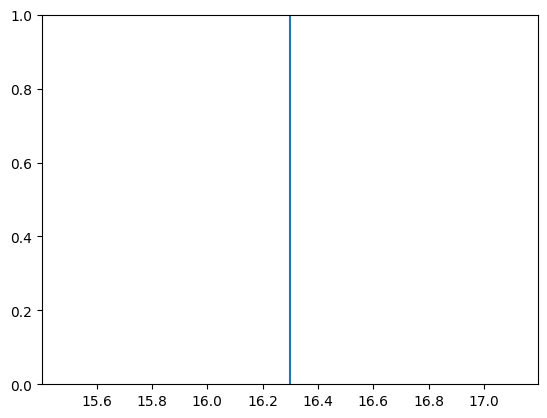

In [770]:
column_count = ds_filtrado.shape[1]
ds_plot = ds_filtrado.T.isna().sum() * 100 / column_count


plt.axvline(ds_plot.mean())
#sns.violinplot(ds_plot)

Analizaremos nuevamente el porcentaje por fila luego de trabajar con las columnas

### Procesado de columnas

Descartaremos la columna id debido a que no es relevante para nuestro análisis. No podemos usar un dato uníco porque no representa ninguna característica relevante.

In [771]:
ds_filtrado['id'].head()

25    CyZu6IaZgmQYGk8jmPajCg==
42    d3Z0MblSb2IMBoOBMGJEEQ==
43    rL7qPkQnomsMGu2ViS3sBw==
49    vuX/ccLAMVml4qWRFcOJUA==
51    ZTtSCeqZ3HUgf5jjwEzRcw==
Name: id, dtype: object

Como mencionamos anteriormente, evaluaremos descartar place_l4 por la cantidad de valores faltantes que hay.

In [772]:
ds_filtrado['place_l4'].value_counts()

Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: place_l4, dtype: int64

Como son pocas observaciones y todas corresponden al barrio de Palermo, descartaremos esta columna. Además, como mencionamos más arriba, la columna created_on siempre es igual a la columna start_date, por lo que también la descartaremos. 

In [773]:
properties_dataset = ds_filtrado.drop(axis="columns", columns=["id", "created_on", "place_l4", "place_l5", "place_l6"]).copy()
print(f"Nuestras nuevas columnas son:\n{properties_dataset.columns.tolist()}")

Nuestras nuevas columnas son:
['start_date', 'end_date', 'latitud', 'longitud', 'place_l2', 'place_l3', 'operation', 'property_type', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price', 'property_currency', 'property_title']


### Analisis de faltantes por fila

Ahora que nos quedamos solo con las columnas deseadas, analizaremos nuevamente los datos faltantes por fila.

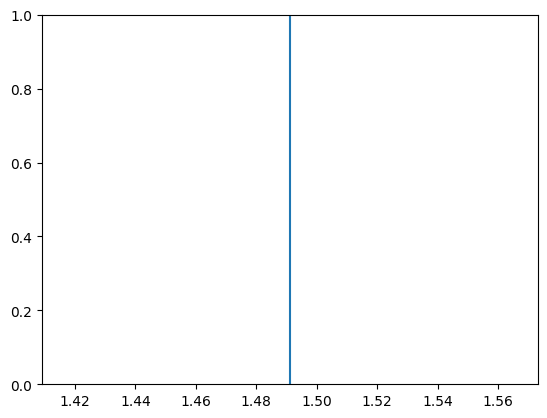

In [774]:
column_count = ds_filtrado.shape[1]
ds_plot = properties_dataset.T.isna().sum() * 100 / column_count

#sns.violinplot(ds_plot)
plt.axvline(ds_plot.mean())

Como podemos ver en el gráfico, la cantidad de datos faltantes bajó muchísimo al eliminar las columnas. Tenemos algunos registros con 5 o 10% de datos faltantes, veremos que falta

In [775]:
properties_dataset['row_missing_data'] = properties_dataset.T.isna().sum() * 100 / column_count
properties_dataset['row_missing_data'].value_counts()

0.0     72863
5.0     16019
10.0     4333
15.0      820
20.0      110
25.0      103
30.0        1
Name: row_missing_data, dtype: int64

In [776]:
dataset_perc = properties_dataset['row_missing_data'].value_counts() * 100 / properties_dataset.shape[0]
print(f"La cantidad de faltantes segun porcentaje representan\n{dataset_perc}")

La cantidad de faltantes segun porcentaje representan
0.0     77.309043
5.0     16.996467
10.0     4.597396
15.0     0.870036
20.0     0.116712
25.0     0.109285
30.0     0.001061
Name: row_missing_data, dtype: float64


<AxesSubplot: >

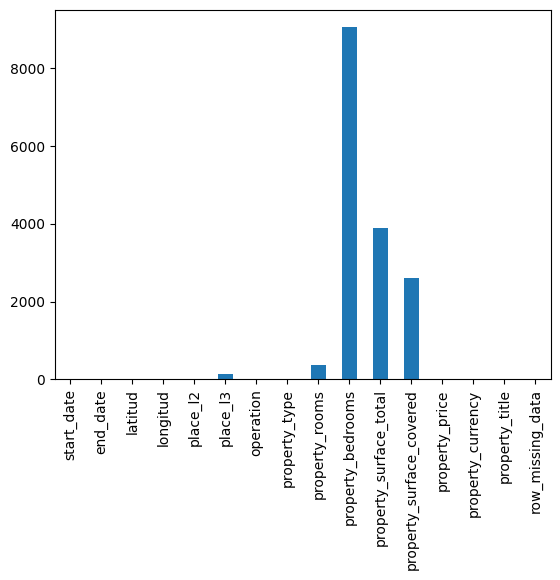

In [777]:
properties_dataset.groupby('row_missing_data').get_group(5).isna().sum().plot.bar()

In [778]:
properties_dataset.groupby('row_missing_data').get_group(10).isna().sum()

start_date                     0
end_date                       0
latitud                     2824
longitud                    2824
place_l2                       0
place_l3                      91
operation                      0
property_type                  0
property_rooms               442
property_bedrooms           1331
property_surface_total       612
property_surface_covered     542
property_price                 0
property_currency              0
property_title                 0
row_missing_data               0
dtype: int64

Ahora que elegimos las columnas deseadas, veremos nuevamente los porcentajes por columna para preparar algunas imputaciones

In [779]:
def plot_missing_by_column(dataset):
    percent_missing = dataset.isna().sum() * 100 / len(dataset)
    plt.figure(figsize=(12, 6))
    percent_missing.plot.bar(x='index', rot=45)
    plt.xlabel("Columns")
    plt.ylabel("Percentage Missing")
    rows = dataset.shape[0]
    print(dataset.isna().sum() / rows * 100)

start_date                   0.000000
end_date                     0.000000
latitud                      3.957602
longitud                     3.957602
place_l2                     0.000000
place_l3                     0.442445
operation                    0.000000
property_type                0.000000
property_rooms               1.107704
property_bedrooms           11.657418
property_surface_total       5.139577
property_surface_covered     3.558658
property_price               0.000000
property_currency            0.000000
property_title               0.000000
row_missing_data             0.000000
dtype: float64


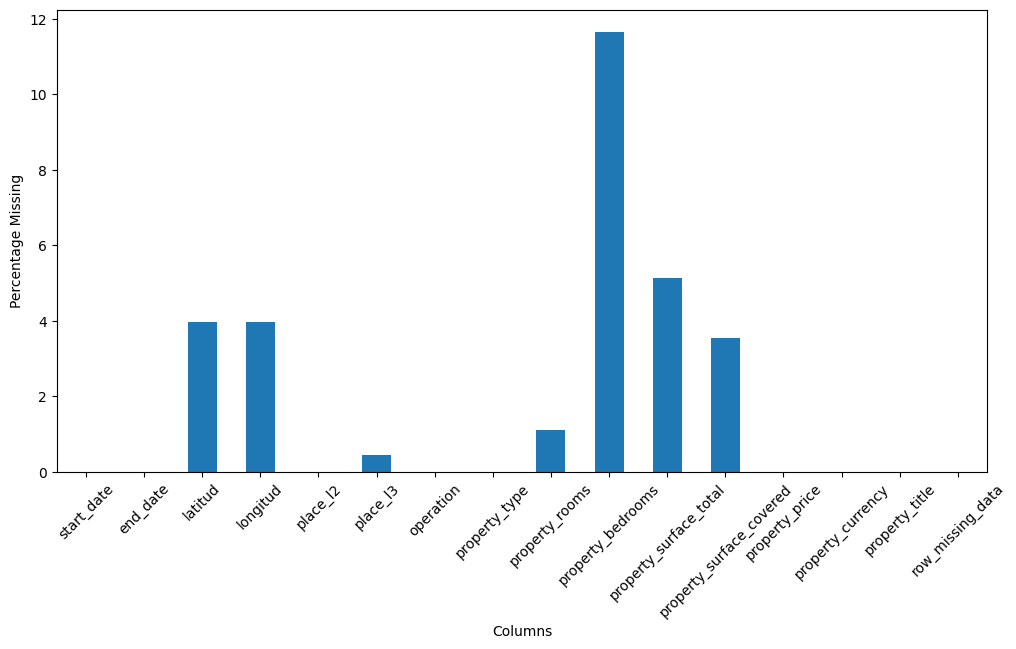

In [780]:
plot_missing_by_column(properties_dataset)

## Imputaciones

Ahora analizaremos columna a columna como podemos reparar esos datos.

#### Latitud y Longitud

In [781]:
len(properties_dataset[properties_dataset.latitud.isna()]), properties_dataset[properties_dataset.latitud.isna()].longitud.isna().sum()

(3730, 3730)

Como vemos, en esos 3730 los registros faltan ambos datos, veremos que datos sí están presentes en esos registros

start_date                    0.000000
end_date                      0.000000
latitud                     100.000000
longitud                    100.000000
place_l2                      0.000000
place_l3                      4.557641
operation                     0.000000
property_type                 0.000000
property_rooms                3.297587
property_bedrooms            13.324397
property_surface_total        7.319035
property_surface_covered      4.343164
property_price                0.000000
property_currency             0.000000
property_title                0.000000
row_missing_data              0.000000
dtype: float64


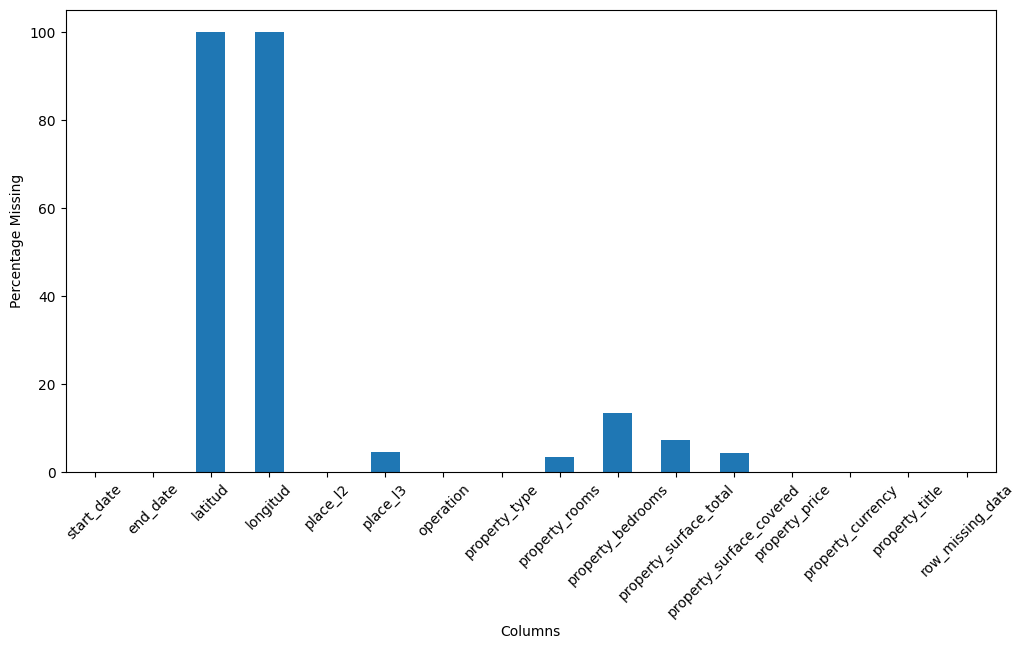

In [782]:
plot_missing_by_column(properties_dataset[properties_dataset.latitud.isna()])

In [783]:
properties_dataset[properties_dataset.latitud.isna()]['place_l3'].value_counts()

Palermo                 907
Belgrano                651
Nuñez                   229
Recoleta                227
Barrio Norte            185
Caballito               170
Almagro                 162
Villa Urquiza           151
Flores                  115
Villa Crespo            111
San Telmo                96
Balvanera                80
Puerto Madero            69
Coghlan                  47
San Nicolás              46
Congreso                 39
Once                     36
Tribunales               32
Monserrat                27
Retiro                   18
Constitución             14
Barracas                 14
Abasto                   12
Paternal                 10
Colegiales               10
Liniers                  10
Saavedra                  9
Villa del Parque          9
Floresta                  8
Mataderos                 7
Parque Chacabuco          7
San Cristobal             7
Villa Devoto              7
Villa Pueyrredón          5
Villa Lugano              4
Pompeya             

In [784]:
percentage = properties_dataset[properties_dataset.latitud.isna()]['place_l3'].isna().sum() / len(properties_dataset[properties_dataset.latitud.isna()]['place_l3']) * 100
print(f"Los datos faltantes en la columna place_l3 representan el {round(percentage, 3)}%")

Los datos faltantes en la columna place_l3 representan el 4.558%


Para los que tienen el dato del barrio podríamos tomar como latitud/longitud

## Reparacion de datos faltantes

### Pre Imputacion de ambientes

index             0.000000
property_title    0.000000
property_rooms    1.107704
dtype: float64


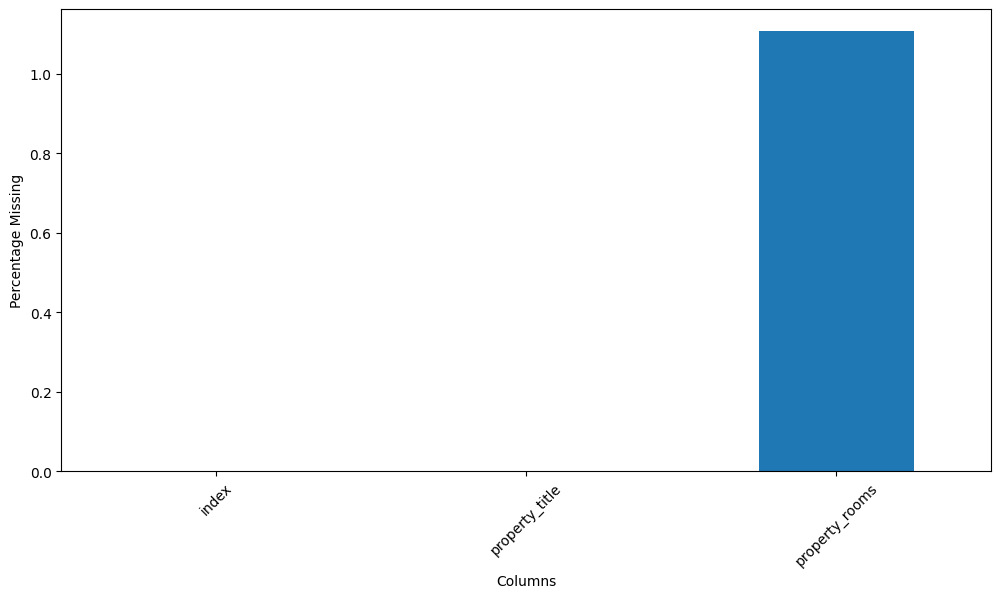

In [785]:
plot_missing_by_column(ds_filtrado[['property_title', 'property_rooms']].reset_index())

## Reparacion de ambientes faltantes en base al titulo de la propiedad

In [786]:
"""datos_a_reparar = ds_filtrado[['property_title', 'property_rooms']].reset_index()
ambientes_faltantes = datos_a_reparar[datos_a_reparar['property_rooms'].isna()]

print(f"cantidad inicial de ambientes a reparar: {len(ambientes_faltantes)}")

regex = re.compile(r"(\d+ \bambientes?\b)")
regex2 = re.compile(r"(\d+\ \b\bamb\b *)")

a = {}
for titulo in ambientes_faltantes.property_title:
    if (len(re.findall(regex, titulo.lower())) > 0):
        a[titulo] = re.findall(regex, titulo.lower())
    if (len(re.findall(regex2, titulo.lower())) > 0):
        a[titulo] = re.findall(regex2, titulo.lower())

cantidad_filas = len(datos_a_reparar)
indice = 0

for titulo in datos_a_reparar.property_title:
    if titulo in a and indice < cantidad_filas:
        if (len(a[titulo]) > 0):
            datos_a_reparar.loc[indice, 'property_rooms'] =  float("".join(a[titulo]).split(" ")[0])
    if ("monoambiente" in titulo.lower()):
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(1)
    indice += 1

cantidad_filas = len(datos_a_reparar)
indice = 0

for titulo in datos_a_reparar.property_title:
    if indice < cantidad_filas:
        if "un ambiente" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(1)
        if "dos ambientes" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(2)
        if "tres ambientes" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(3)
        if "cuatro ambientes" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(4)
        if "cinco ambientes" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(5)
        if "seis ambientes" in titulo.lower():
            datos_a_reparar.loc[indice, 'property_rooms'] =  float(6)
    indice += 1

ds_filtrado.property_rooms = datos_a_reparar.property_rooms
print(f"cantidad de ambientes faltantes post reparacion: {len(datos_a_reparar[datos_a_reparar['property_rooms'].isna()])}")"""

'datos_a_reparar = ds_filtrado[[\'property_title\', \'property_rooms\']].reset_index()\nambientes_faltantes = datos_a_reparar[datos_a_reparar[\'property_rooms\'].isna()]\n\nprint(f"cantidad inicial de ambientes a reparar: {len(ambientes_faltantes)}")\n\nregex = re.compile(r"(\\d+ \x08ambientes?\x08)")\nregex2 = re.compile(r"(\\d+\\ \x08\x08amb\x08 *)")\n\na = {}\nfor titulo in ambientes_faltantes.property_title:\n    if (len(re.findall(regex, titulo.lower())) > 0):\n        a[titulo] = re.findall(regex, titulo.lower())\n    if (len(re.findall(regex2, titulo.lower())) > 0):\n        a[titulo] = re.findall(regex2, titulo.lower())\n\ncantidad_filas = len(datos_a_reparar)\nindice = 0\n\nfor titulo in datos_a_reparar.property_title:\n    if titulo in a and indice < cantidad_filas:\n        if (len(a[titulo]) > 0):\n            datos_a_reparar.loc[indice, \'property_rooms\'] =  float("".join(a[titulo]).split(" ")[0])\n    if ("monoambiente" in titulo.lower()):\n            datos_a_reparar.lo

### Post Imputacion de ambientes

In [787]:
"""plot_missing_by_column(datos_a_reparar)"""

'plot_missing_by_column(datos_a_reparar)'

### Pre Imputacion de Habitaciones

index                 0.000000
property_bedrooms    11.657418
dtype: float64


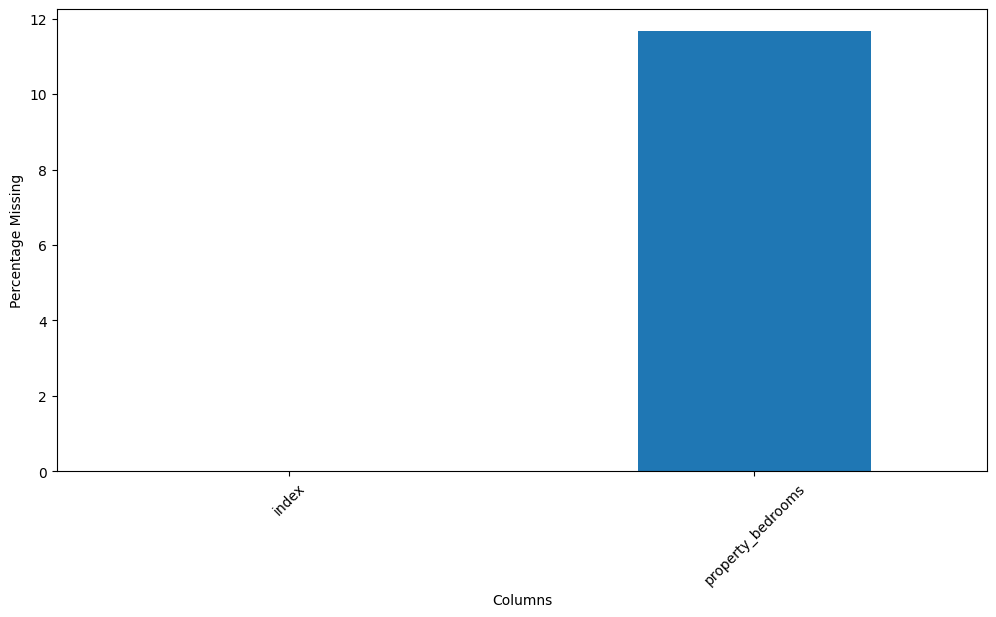

In [788]:
plot_missing_by_column(ds_filtrado['property_bedrooms'].reset_index())

In [789]:
print(f"El total de habitaciones es: {len(ds_filtrado.property_bedrooms)}")
habitaciones_invalidas = ds_filtrado.loc[(ds_filtrado['property_bedrooms'] > ds_filtrado['property_rooms'])]
print(f"El total de habitaciones invalidas es: {len(habitaciones_invalidas)}. Constituye al {(len(habitaciones_invalidas) * 100)//len(ds_filtrado.property_bedrooms)}% de los datos del ds")
habitaciones_invalidas

El total de habitaciones es: 94249
El total de habitaciones invalidas es: 151. Constituye al 0% de los datos del ds


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
2516,uKy3ZC5YQ9kPZ1ztj7CKjw==,2021-12-17,2022-02-09,2021-12-17,-34.557573,-58.459926,Capital Federal,Belgrano,NaN,NaN,NaN,Venta,Departamento,1.0,2.0,51.0,51.0,150000.0,USD,Venta Departamento 2 Ambientes Belgrano a Estr...
3028,epPD4VV0HDOb5M1cNSTFEw==,2021-02-20,2021-03-01,2021-02-20,-34.640603,-58.417313,Capital Federal,Pompeya,NaN,NaN,NaN,Venta,PH,1.0,2.0,27.0,22.0,53000.0,USD,"P.H. AL FRENTE C/ ENTRADA IND., S/ EXPENSAS"
4928,69j280NshNyMCYcFqsmhlw==,2021-09-20,2022-01-27,2021-09-20,-34.645031,-58.373672,Capital Federal,Barracas,NaN,NaN,NaN,Venta,Departamento,1.0,2.0,43.0,37.0,80000.0,USD,Amplio Monoambiente - actualmente divido - con...
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,2021-10-29,-34.577180,-58.451264,Capital Federal,Colegiales,NaN,NaN,NaN,Venta,Departamento,6.0,8.0,424.0,324.0,660000.0,USD,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...
9491,ybK3GgBY+bzoeAA+YONVcQ==,2021-05-18,2021-06-05,2021-05-18,-34.580919,-58.430717,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,2.0,97.0,97.0,263000.0,USD,Departamento - Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451218,7krE2YAxkwyebVtlLkuFcA==,2021-12-16,2022-01-27,2021-12-16,-34.557917,-58.459907,Capital Federal,Belgrano,NaN,NaN,NaN,Venta,Departamento,1.0,2.0,49.0,45.0,136300.0,USD,Departamento - Belgrano
452275,DzALh3DQ7Dp1VmfhkZvL4w==,2021-12-16,2022-02-09,2021-12-16,-34.596921,-58.402560,Capital Federal,Recoleta,NaN,NaN,NaN,Venta,Departamento,4.0,5.0,108.0,100.0,220000.0,USD,VENTA DEPTO 4 AMB DEPENDENCIA BALCON BARRIO NORTE
458670,naEatqtTCG8ALXICib4ZxQ==,2021-01-05,2022-08-12,2021-01-05,-34.577390,-58.475421,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,PH,5.0,6.0,125.0,100.0,265000.0,USD,Alvarez Thomas 2400 Exc PH SIN EXPENSAS- 5 am...
459345,tDk6Qv0vzIsLSAkJbV/O/Q==,2021-01-05,2021-06-24,2021-01-05,-34.578661,-58.428397,Capital Federal,Palermo,Palermo Hollywood,NaN,NaN,Venta,Departamento,2.0,3.0,82.0,73.0,192000.0,USD,Excelente oportunidad dpto en Palermo Hollywoo...


Si tomamos en cuenta que el 2% de los valores tienen mas habitaciones que ambientes, podriamos pensar en imputar los datos faltantes elimanando estas filas y haciendo que los valores que sean NAN, ahora sean habitaciones = ambientes-1

In [790]:
habitaciones_con_amb_menos_1 = ds_filtrado[ds_filtrado.property_rooms == (ds_filtrado.property_bedrooms + 1)]
print(f"Las habitaciones que son Ambientes - 1 son: {len(habitaciones_con_amb_menos_1)}. Constituyen al {(len(habitaciones_con_amb_menos_1) * 100)//len(ds_filtrado.property_bedrooms)}% de los datos")
habitaciones_con_amb_menos_1

Las habitaciones que son Ambientes - 1 son: 69641. Constituyen al 73% de los datos


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,2.0,1.0,61.0,46.0,100000.0,USD,PH 2 Ambientes c/Patio HECHO A NUEVO
56,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,2021-09-26,2021-09-09,-34.629398,-58.425852,Capital Federal,Boedo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,62.0,44.0,100000.0,USD,VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460066,6jIQwemq6hMLyB3vfivamA==,2021-01-05,2021-06-05,2021-01-05,-34.632484,-58.432932,Capital Federal,Parque Chacabuco,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,NaN,76.0,129000.0,USD,DEPARTAMENTO VENTA PARQUE CHACABUCO 3 AMBIENTES
460067,pKo6hHHPBZJydrHIn5S5Tg==,2021-01-05,2021-11-04,2021-01-05,-34.636285,-58.400321,Capital Federal,Parque Patricios,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,66.0,64.0,130000.0,USD,Atractivo depto en el edificio histórico del P...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,USD,Espectacular 4 amb130m2 con Balcon Terraza!!!
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,USD,3 ambientes con cochera listo para habitar!


Como notamos que las habitaciones que son ambientes - 1 en el dataset son: 4255 y constituyen al 4% de los datos, optamos por hacer una regresion lineal para que se pueda predecir el valor de las habitaciones en base a los ambientes que tenemos, ya que el 4% no es un valor representativo

In [791]:
print(f"Valor inicial de habitaciones faltantes en el ds: {ds_filtrado.property_bedrooms.isna().sum()}")

Valor inicial de habitaciones faltantes en el ds: 10987


In [792]:
## Approach de Regresion para imputar los valores faltantes en las habitaciones

lr = LinearRegression()

ds_sin_rooms_vacios = ds_filtrado[~(ds_filtrado.property_rooms.isna())]

habitaciones_completas = ds_sin_rooms_vacios[~(ds_sin_rooms_vacios.property_bedrooms.isna())]
habitaciones_faltantes = ds_sin_rooms_vacios[ds_sin_rooms_vacios.property_bedrooms.isna()]
train_bedrooms =  habitaciones_completas.property_bedrooms.values
train_rooms = habitaciones_completas.property_rooms.values

train_bedrooms = train_bedrooms.reshape(-1, 1)
train_rooms = train_rooms.reshape(-1, 1)

lr.fit(train_rooms,train_bedrooms)

test_rooms =  habitaciones_faltantes.property_rooms.values.reshape(-1, 1)

predicted_bedrooms = lr.predict(test_rooms)

habitaciones_faltantes_copy = habitaciones_faltantes.copy()
habitaciones_faltantes_copy['result'] = np.round(predicted_bedrooms)

print(f"Proseguimos en verificar que podemos usar el metodo de regresion lineal ya que la variable que vamos a imputar esta entre un rango de 0 - 5")
print(f"Notemos que las habitaciones mayores a cinco son: {len(habitaciones_faltantes_copy[habitaciones_faltantes_copy.result > 5])}")

for i in ds_filtrado.index:
    if i in habitaciones_faltantes_copy.index:
        ds_filtrado.loc[i, 'property_bedrooms'] = habitaciones_faltantes_copy.loc[i, 'result']
        
print(ds_filtrado.property_bedrooms.isna().sum())

Proseguimos en verificar que podemos usar el metodo de regresion lineal ya que la variable que vamos a imputar esta entre un rango de 0 - 5
Notemos que las habitaciones mayores a cinco son: 31
432


## Grafico de los barrios de CABA

In [793]:
# Proceso el archivo de los barrios de CABA
barrios = gpd.read_file('./mapa/barrios.geojson')
barrios.head()

,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


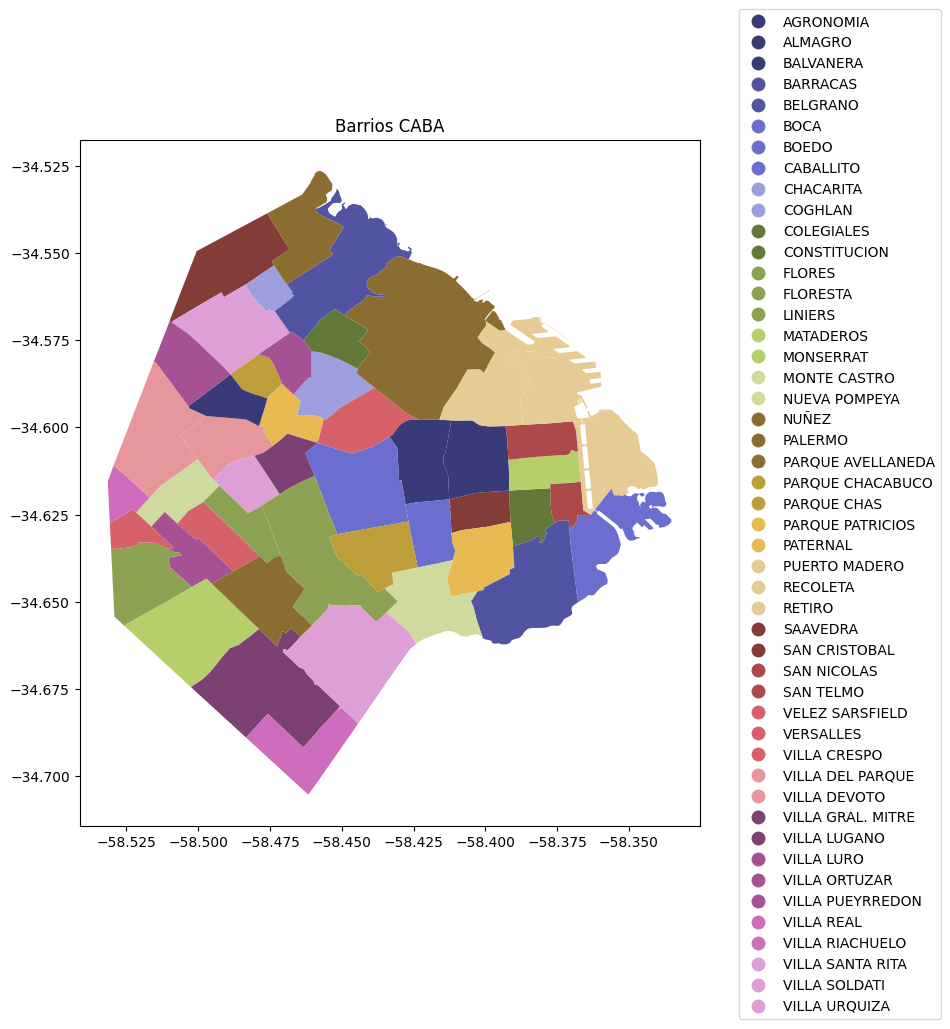

In [794]:
# Realizo el grafico de los barrios de CABA
fig, ax = plt.subplots(figsize=(8,10))
barrios.plot(column='BARRIO', categorical=True, legend=True, ax=ax, cmap='tab20b')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 1.2))

ax.set(title='Barrios CABA')
plt.show()

# Univariados

#### Latitud y Longitud

Verificamos que todos los registros tengan datos válidos de latitúd y longitud

#### property_rooms

<AxesSubplot: ylabel='property_rooms'>

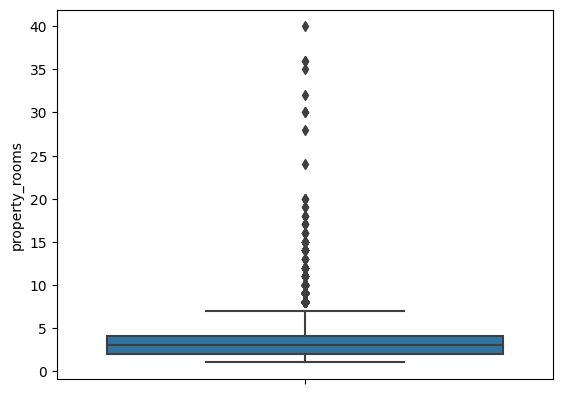

In [795]:
sns.boxplot(y=ds_filtrado.property_rooms)


In [796]:
ds_filtrado.property_rooms.describe()

count    93205.000000
mean         2.822799
std          1.426148
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         40.000000
Name: property_rooms, dtype: float64

In [797]:
Q1_ambientes = ds_filtrado.property_rooms.quantile(q=0.25)
Q3_ambientes = ds_filtrado.property_rooms.quantile(q=0.75)
IQR_ambientes = Q3_ambientes - Q1_ambientes
limite_superior_ambientes = Q3_ambientes+ IQR_ambientes * 1.5
print(limite_superior_ambientes)

ds_filtrado[ds_filtrado.property_rooms <= limite_superior_ambientes]

7.0


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,USD,Espectacular 4 amb130m2 con Balcon Terraza!!!
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,USD,3 ambientes con cochera listo para habitar!
460074,Rmamz8v4Wkh5xF7PA59Jqw==,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,51.0,30.0,75500.0,USD,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...
460075,7yl8Dfx5wobH21YdMU+Kgg==,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,37.0,31.0,74500.0,USD,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...


In [798]:
ds_filtrado.property_rooms.describe()

count    93205.000000
mean         2.822799
std          1.426148
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         40.000000
Name: property_rooms, dtype: float64

<AxesSubplot: ylabel='property_rooms'>

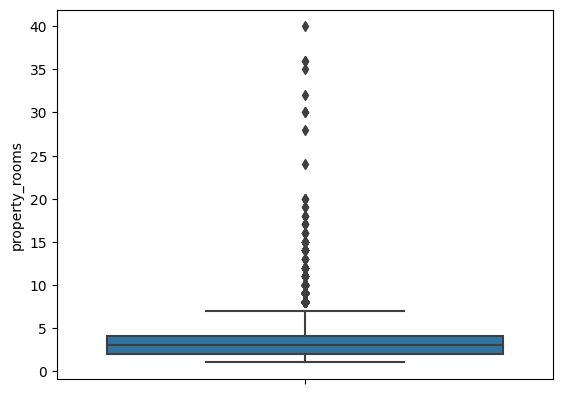

In [799]:
sns.boxplot(y=ds_filtrado.property_rooms)


#### property_bedrooms

<AxesSubplot: title={'center': 'Grafico'}, xlabel='Cantidad de habitaciones'>

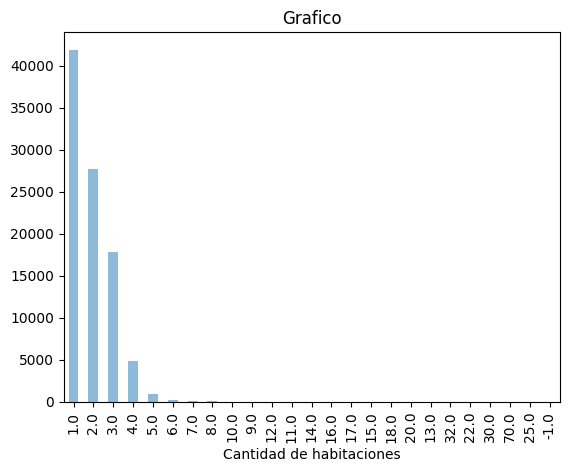

In [800]:
ds_filtrado.property_bedrooms.value_counts().plot.bar(alpha=0.5, title= 'Grafico', xlabel= 'Cantidad de habitaciones')

In [801]:
ds_filtrado[ds_filtrado.property_bedrooms == -1]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


In [802]:
ds_filtrado = ds_filtrado[ds_filtrado.property_bedrooms > -1]

In [803]:
ds_filtrado.property_bedrooms.describe()

count    93816.000000
mean         1.912648
std          1.119703
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         70.000000
Name: property_bedrooms, dtype: float64

In [804]:
Q1_habitaciones = ds_filtrado.property_bedrooms.quantile(q=0.25)
Q3_habitaciones = ds_filtrado.property_bedrooms.quantile(q=0.75)
IQR_habitaciones = Q3_habitaciones - Q1_habitaciones
limite_superior_habitaciones = Q3_habitaciones + IQR_habitaciones * 1.5
print(limite_superior_habitaciones)

ds_filtrado = ds_filtrado[ds_filtrado.property_bedrooms <= limite_superior_habitaciones]

6.0


In [805]:
ds_filtrado.property_rooms.describe()

count    92938.000000
mean         2.801050
std          1.346072
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         40.000000
Name: property_rooms, dtype: float64

#### property_surface_total

<AxesSubplot: ylabel='property_surface_total'>

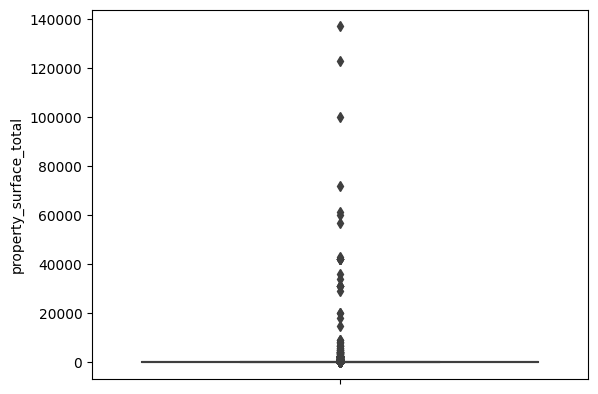

In [806]:
sns.boxplot(y=ds_filtrado.property_surface_total)

In [807]:
Q1_superficie_total = ds_filtrado.property_surface_total.quantile(q=0.25)
Q3_superficie_total = ds_filtrado.property_surface_total.quantile(q=0.75)
IQR_superficie_total = Q3_superficie_total- Q1_superficie_total
limite_superior_superficie_total = Q3_superficie_total + IQR_superficie_total * 3
print(limite_superior_superficie_total)

ds_filtrado = ds_filtrado[ds_filtrado.property_surface_total <= limite_superior_superficie_total]

281.0


In [808]:
ds_filtrado.property_surface_total.describe()

count    85736.000000
mean        79.625805
std         50.465064
min         10.000000
25%         44.000000
50%         64.000000
75%         98.000000
max        281.000000
Name: property_surface_total, dtype: float64

<AxesSubplot: ylabel='property_surface_total'>

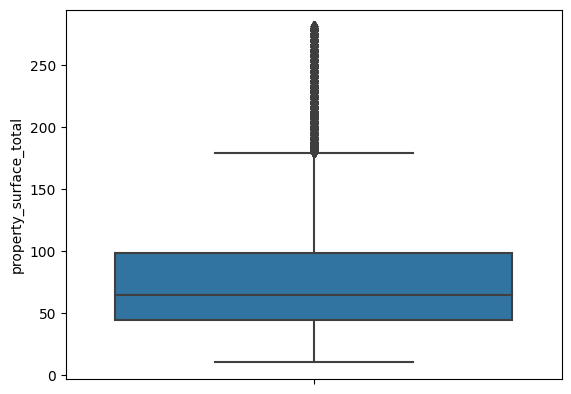

In [809]:
sns.boxplot(y=ds_filtrado.property_surface_total)

#### property_surface_covered

<AxesSubplot: ylabel='property_surface_covered'>

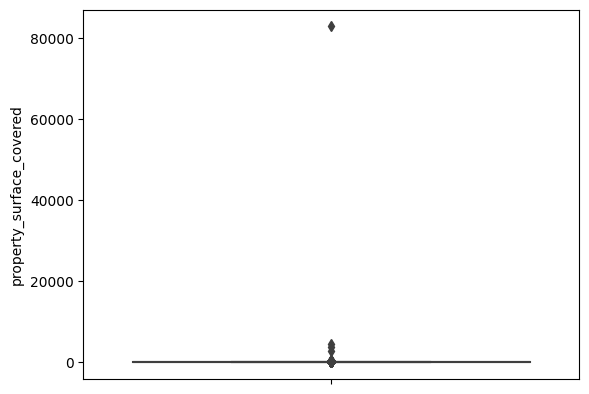

In [810]:
sns.boxplot(y=ds_filtrado.property_surface_covered)

In [811]:
ds_filtrado.property_surface_covered.describe()

count    82561.000000
mean        70.056964
std        292.577247
min          1.000000
25%         40.000000
50%         56.000000
75%         82.000000
max      83000.000000
Name: property_surface_covered, dtype: float64

In [812]:
Q1_superficie_cubierta= ds_filtrado.property_surface_covered.quantile(q=0.25)
Q3_superficie_cubierta = ds_filtrado.property_surface_covered.quantile(q=0.75)
IQR_superficie_cubierta = Q3_superficie_cubierta - Q1_superficie_cubierta
limite_superior_superficie_cubierta= Q3_superficie_cubierta+ IQR_superficie_cubierta * 3
print(limite_superior_superficie_cubierta)

ds_filtrado = ds_filtrado[ds_filtrado.property_surface_covered <= limite_superior_superficie_cubierta]


208.0


In [813]:
ds_filtrado.property_surface_covered.describe()

count    81220.000000
mean        66.152007
std         36.821789
min          1.000000
25%         40.000000
50%         55.000000
75%         80.000000
max        208.000000
Name: property_surface_covered, dtype: float64

<AxesSubplot: ylabel='property_surface_covered'>

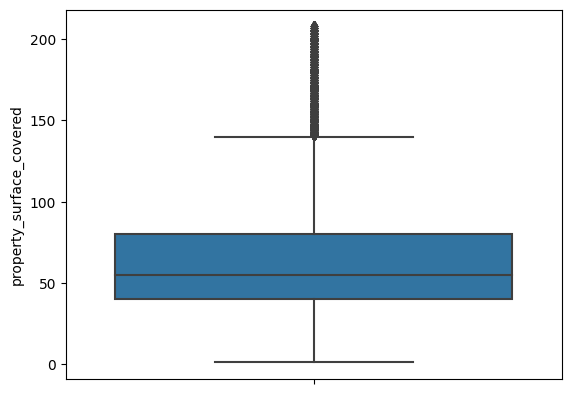

In [814]:
sns.boxplot(y=ds_filtrado.property_surface_covered)

#### property_price

<AxesSubplot: ylabel='property_price'>

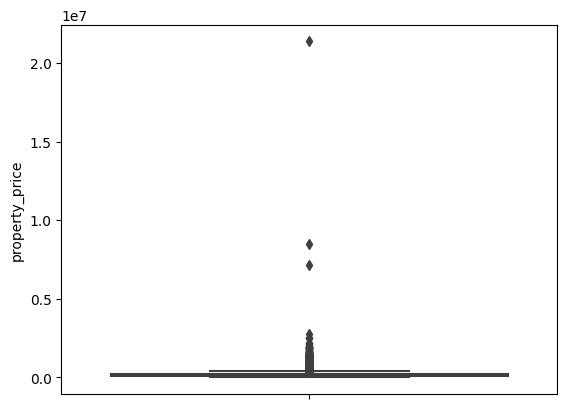

In [815]:
sns.boxplot(y=ds_filtrado.property_price)

In [816]:
ds_filtrado.property_price.describe()

count    8.122000e+04
mean     1.823982e+05
std      1.731017e+05
min      5.000000e+03
25%      9.400000e+04
50%      1.370000e+05
75%      2.150000e+05
max      2.140000e+07
Name: property_price, dtype: float64

<AxesSubplot: ylabel='property_price'>

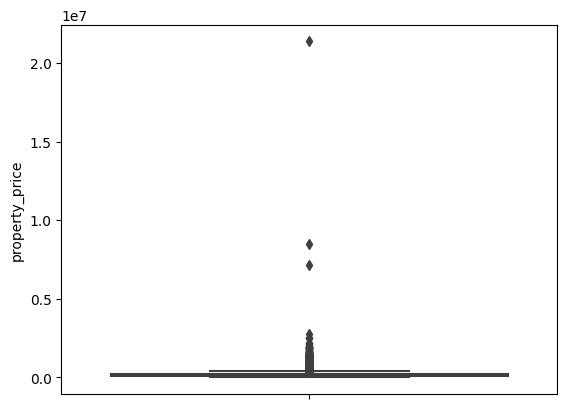

In [817]:
sns.boxplot(y=ds_filtrado.property_price)

In [818]:
Q1_precio_propiedad= ds_filtrado.property_price.quantile(q=0.25)
Q3_precio_propiedad = ds_filtrado.property_price.quantile(q=0.75)
IQR_precio_propiedad = Q3_precio_propiedad - Q1_precio_propiedad
limite_superior_precio_propiedad = Q3_precio_propiedad+ IQR_precio_propiedad * 3
print(limite_superior_precio_propiedad)

ds_filtrado = ds_filtrado[ds_filtrado.property_price <= limite_superior_precio_propiedad]

578000.0


In [819]:
ds_filtrado.property_price.describe()

count     79035.000000
mean     164413.763231
std      100901.424360
min        5000.000000
25%       92000.000000
50%      135000.000000
75%      200000.000000
max      577700.000000
Name: property_price, dtype: float64

<AxesSubplot: ylabel='property_price'>

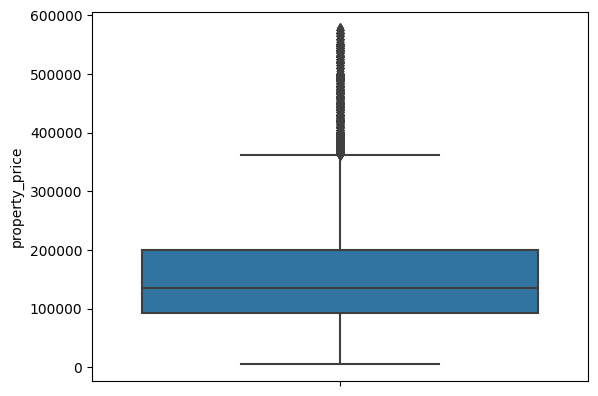

In [820]:
sns.boxplot(y=ds_filtrado.property_price)

## Multivariado

In [821]:
def mahalanobis(df, columnas):
    # En este caso solo calculo la diagonal, ya que con un dataset de este tamaño es imposible calcular la matriz entera para luego solo quedarse con la diagonal.
    df_reducido = df[columnas].copy()

    x_dif = df_reducido[columnas] - np.mean(df_reducido[columnas])
    cov=df_reducido[columnas].cov().values
    inv_cov = np.linalg.inv(cov)
    x_dif_menos_inv_cov = np.dot(x_dif, inv_cov)
    mahal = np.empty(len(x_dif_menos_inv_cov))

    for i in range(len(x_dif_menos_inv_cov)):
        mahal[i] = x_dif_menos_inv_cov[i].dot(x_dif.iloc[i].T)

    return mahal

### Verficiar Latitud y Longitud

Con la distancia de mahalanobis se puede ver si hay valores que se encuentran alejados de Capital Federal, ya que la gran mayoría se encuentran en un rango muy cerrado numérico

In [822]:
ds_filtrado['Mahalanobis coordenadas'] = mahalanobis(ds_filtrado, ['latitud','longitud'])
radio_maximo = 20
ds_filtrado[ds_filtrado['Mahalanobis coordenadas'] > radio_maximo]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,...,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,Mahalanobis coordenadas
9153,PGEusvkhHkst1cMhvxu/WA==,2021-05-18,2021-06-23,2021-05-18,-33.081030,-68.468140,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,USD,Venta 3 ambientes San Martín Centro Gran Balcon,1614.978032
12962,PxTxkVaOSszP5lWImkFyyw==,2021-03-01,2021-03-01,2021-03-01,-27.469213,-58.830635,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,2.0,1.0,55.0,55.0,120000.0,USD,Depto Apto Profesional 70mt2 - Microcentro,2269.041214
25574,5AF0wjAb/TIyttOJjURixw==,2021-06-24,2022-02-09,2021-06-24,-33.081030,-68.468140,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,3.0,2.0,66.0,60.0,75000.0,USD,Venta 3 ambientes San Martín Centro Gran VISTA,1614.978032
32663,5u4y8J+u23vDmBB1/xiVSw==,2021-02-08,2021-07-21,2021-02-08,-33.024661,-60.616610,Capital Federal,NaN,NaN,NaN,...,Venta,Casa,NaN,2.0,214.0,100.0,75000.0,USD,Casa de 2 dormitorios !!,166.022241
32705,5GwRAQ+RyU4uOxF0LOxKuw==,2021-02-08,2022-03-25,2021-02-08,-24.770804,-65.400812,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,2.0,1.0,124.0,64.0,240000.0,USD,Venta Departamento Terrazas Golf Pilará,4713.196798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411053,y41y+zCHtknU3E19ftou1A==,2021-03-02,2021-06-05,2021-03-02,-32.993973,-60.626941,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,4.0,2.0,55.0,55.0,20000.0,USD,"Departamento 2 dormitorios , amplio. zona sur.",170.630096
411058,pUcVtnFyfRaD8YhgT/GMEQ==,2021-03-02,2021-06-05,2021-03-02,-32.964094,-60.629053,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,1.0,1.0,34.0,34.0,52000.0,USD,Departamento MONOAMBIENTE A ESTRENAR contrafre...,174.719201
424020,gs9mOziVxiwQyC/HrVTWNA==,2021-12-16,2022-03-25,2021-12-16,-30.436760,-64.317055,Capital Federal,NaN,NaN,NaN,...,Venta,Casa,6.0,3.0,172.0,112.0,134000.0,USD,Venta Casa en Manzanares Barrio Abierto,1184.650463
448128,HRFCaJgDzUO+/lyKG46ZMw==,2021-12-16,2022-02-09,2021-12-16,-33.081030,-68.468140,Capital Federal,NaN,NaN,NaN,...,Venta,Departamento,1.0,1.0,38.0,38.0,89500.0,USD,DEPTO A ESTR. COCHERA PISCINA PISTA DE ATLETISMO,1614.978032


Analizando los datos todos parecen estar por fuera de las coordenadas de Capital Federal, lo más probable es que el mal input se encuentre en el campo de place_l2 en vez de la látitud y lóngitud. Por lo que son propiedades que no tenemos que considerar en el cálculo por lo que podemos quitarlas.

In [823]:
ds_filtrado = ds_filtrado[ds_filtrado['Mahalanobis coordenadas'] <= radio_maximo]

In [824]:
ds_filtrado.drop('Mahalanobis coordenadas', axis=1, inplace=True)

/tmp/ipykernel_47005/4294332605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado.drop('Mahalanobis coordenadas', axis=1, inplace=True)


### Relación entre superficie total y cubierta

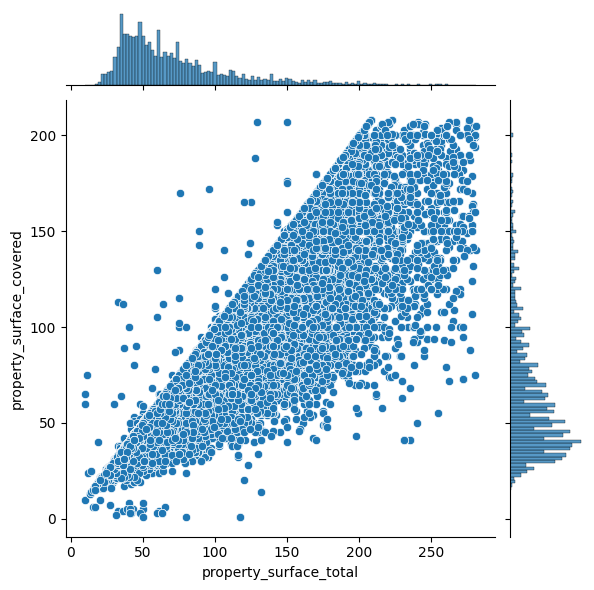

In [825]:
sns.jointplot(data=ds_filtrado, x=ds_filtrado.property_surface_total, y= ds_filtrado.property_surface_covered)

Una propiedad no puede tener más superficie cubierta que total

In [826]:
ds_filtrado = ds_filtrado[ds_filtrado.property_surface_covered <= ds_filtrado.property_surface_total] # ELIMINACION OUTLIERS

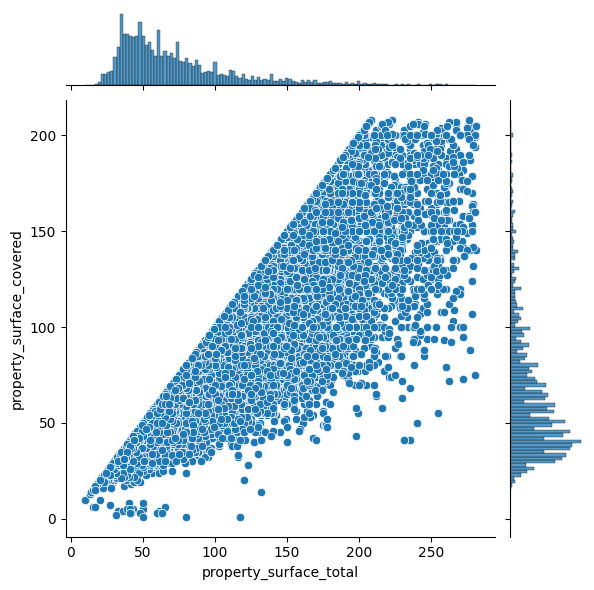

In [827]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_surface_total, y= ds_filtrado.property_surface_covered)

/tmp/ipykernel_47005/4064245507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado['Mahalanobis superficie'] = mahalanobis(ds_filtrado, ['property_surface_total','property_surface_covered', 'property_price'])


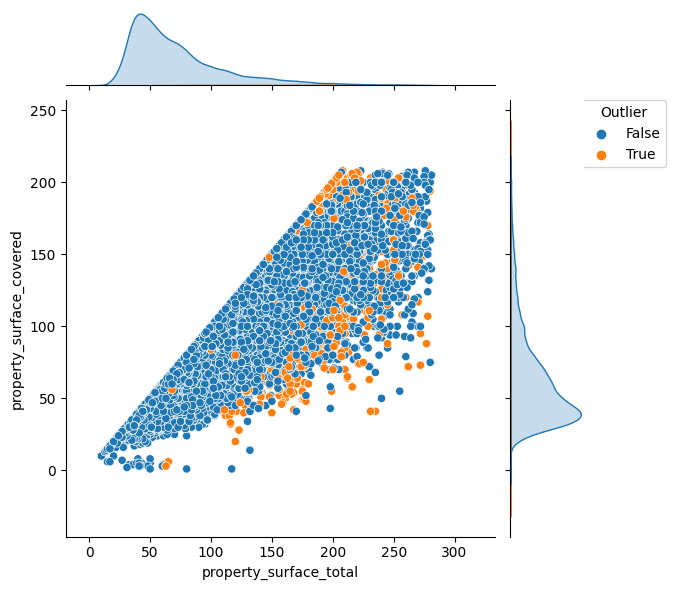

In [828]:

ds_filtrado['Mahalanobis superficie'] = mahalanobis(ds_filtrado, ['property_surface_total','property_surface_covered', 'property_price'])
radio_maximo = 17
ds_filtrado[ds_filtrado['Mahalanobis superficie'] > radio_maximo]
es_outlier = ((ds_filtrado['Mahalanobis superficie'] > radio_maximo) & (ds_filtrado.property_type == 'Departamento'))

sns.jointplot(x=ds_filtrado.property_surface_total,y=ds_filtrado.property_surface_covered, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0, title="Outlier")

In [829]:
es_outlier.value_counts()

False    74703
True      1292
dtype: int64

In [830]:
ds_filtrado[(ds_filtrado['Mahalanobis superficie'] > radio_maximo) & (ds_filtrado.property_type == 'Departamento')]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,...,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,Mahalanobis superficie
653,k3FuLeIEFq9KJotylsHl1Q==,2021-09-09,2022-02-09 00:00:00.000000000,2021-09-09,-34.567191,-58.458145,Capital Federal,Belgrano,NaN,NaN,...,Venta,Departamento,4.0,3.0,226.0,94.0,345000.0,USD,Venta Semipiso 4amb Patio y Cochera - Belgrano,50.427046
905,Pzsb4G2+q+Xd0mYQHHXdVQ==,2021-09-09,2022-01-27 00:00:00.000000000,2021-09-09,-34.597424,-58.492490,Capital Federal,Agronomía,NaN,NaN,...,Venta,Departamento,5.0,3.0,205.0,195.0,395000.0,USD,Departamento - Agronomia,18.526133
1233,1AXI3W1wc1zyMireeV8MOg==,2021-09-09,2021-11-22 10:42:07.845036320,2021-09-09,-34.573180,-58.486896,Capital Federal,Villa Urquiza,NaN,NaN,...,Venta,Departamento,5.0,3.0,120.0,20.0,320000.0,USD,Departamento venta,49.523049
2555,qUqeE+RJHPvgi5UDi5+7ig==,2021-12-17,2022-01-27 00:00:00.000000000,2021-12-17,-34.554667,-58.448950,Capital Federal,Belgrano,NaN,NaN,...,Venta,Departamento,6.0,4.0,221.0,206.0,500000.0,USD,Departamento - Belgrano C,19.611829
2653,BZsXCc9QFotkFIyjkc0atQ==,2021-12-17,2022-02-09 00:00:00.000000000,2021-12-17,-34.605113,-58.405477,Capital Federal,Balvanera,NaN,NaN,...,Venta,Departamento,4.0,3.0,144.0,144.0,98000.0,USD,Departamento 4 ambientes Venta Balvanera Patio,23.117891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459298,ygalOZvFoNJ+tY22TsMBXw==,2021-01-05,2022-04-01 00:00:00.000000000,2021-01-05,-34.593904,-58.381532,Capital Federal,Retiro,NaN,NaN,...,Venta,Departamento,4.0,3.0,179.0,172.0,549000.0,USD,Venta semipiso de categoría,17.222021
459310,I4JJmcGho0jkhY4V0jzVVg==,2021-01-05,2021-03-20 10:42:07.845036320,2021-01-05,-34.593956,-58.380915,Capital Federal,Retiro,NaN,NaN,...,Venta,Departamento,6.0,4.0,189.0,189.0,420000.0,USD,Excelente departamento frances en venta en Ret...,18.071513
459406,cxce8s7ZUpaH6NLzWuyXyA==,2021-01-05,2021-06-05 00:00:00.000000000,2021-01-05,-34.582207,-58.405338,Capital Federal,Palermo,NaN,NaN,...,Venta,Departamento,5.0,3.0,148.0,148.0,570000.0,USD,Excelente duplex en VENTA en Palermo Chico en ...,20.437334
459756,gelwV/1eUr7wLDxrSQmUSg==,2021-01-05,2022-06-11 00:00:00.000000000,2021-01-05,-34.591895,-58.386301,Capital Federal,Recoleta,NaN,NaN,...,Venta,Departamento,4.0,2.0,120.0,80.0,460000.0,USD,Loft de 3 dormitorios en venta en lo mejor de...,18.736863


Lo que inicialmente parecían outliers terminaron siendo en su gran mayoría propiedades que cuentan las terrazas como parte de la superficie total o edificios que cuentan patios también como propios. Dado a que efectivamente están contando como superficie total elementos que no le corresponden se tienen que descartar estos campos en concreto y rehacerse vía regresión lineal a raiz de los otros parámetros.

In [831]:
superficies_correctas = ds_filtrado[(ds_filtrado['Mahalanobis superficie'] > radio_maximo) & (ds_filtrado.property_type == 'Departamento')]

In [832]:
superficies_correctas[['property_surface_total', 'property_price']]

,property_surface_total,property_price
653,226.0,345000.0
905,205.0,395000.0
1233,120.0,320000.0
2555,221.0,500000.0
2653,144.0,98000.0
...,...,...
459298,179.0,549000.0
459310,189.0,420000.0
459406,148.0,570000.0
459756,120.0,460000.0


In [833]:
## Approach de Regresion para imputar los valores faltantes en las habitaciones

lr = LinearRegression()

ds_sin_outliers = ds_filtrado[ds_filtrado['Mahalanobis superficie'] <= radio_maximo]

superficies_correctas = ds_filtrado[ds_filtrado['Mahalanobis superficie'] <= radio_maximo]
superficies_a_modificar = ds_filtrado[ds_filtrado['Mahalanobis superficie'] > radio_maximo]
train_variables =  superficies_correctas[['property_surface_covered', 'property_price']]
train_superficie_total = superficies_correctas.property_surface_covered


lr.fit(train_variables, train_superficie_total)


test_surface =  superficies_a_modificar[['property_surface_covered', 'property_price']]

predicted_surfaces = lr.predict(test_surface)

superficies_faltantes_copy = superficies_a_modificar.copy()
superficies_faltantes_copy['result'] = np.round(predicted_surfaces)


for i in ds_filtrado.index:
    if i in superficies_faltantes_copy.index:
        ds_filtrado.loc[i, 'property_surface_total'] = superficies_faltantes_copy.loc[i, 'result']



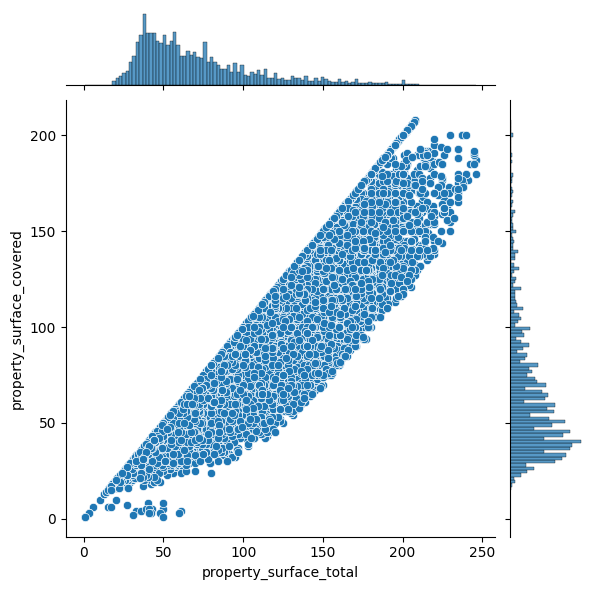

In [834]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_surface_total, y= ds_filtrado.property_surface_covered)

Me fijo al igual que antes que ninguna de las estimaciones realizadas se tenga una superficie cubierta mayor a la total.

In [835]:
len(ds_filtrado[ds_filtrado.property_surface_covered > ds_filtrado.property_surface_total])

0

In [836]:
ds_filtrado.drop('Mahalanobis superficie', axis=1, inplace=True)
ds_filtrado.head()

/tmp/ipykernel_47005/2293503197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado.drop('Mahalanobis superficie', axis=1, inplace=True)


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,2.0,1.0,61.0,46.0,100000.0,USD,PH 2 Ambientes c/Patio HECHO A NUEVO
55,zIXYgKHTdJ5HFYpZ8oROeQ==,2021-09-09,2021-09-19,2021-09-09,-34.625588,-58.423056,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,104.0,54.0,185000.0,USD,PH Venta PH 3 ambientes + Patio + Terraza Divino
56,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,2021-09-26,2021-09-09,-34.629398,-58.425852,Capital Federal,Boedo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,62.0,44.0,100000.0,USD,VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo


### Relacion entre ambientes y habitaciones

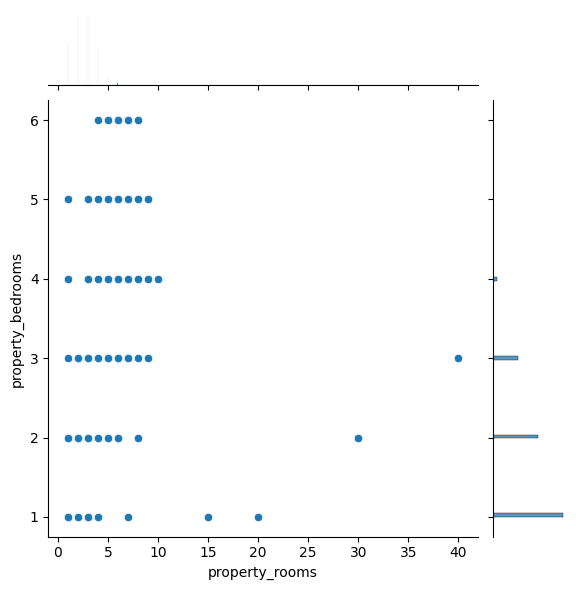

In [837]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_rooms, y= ds_filtrado.property_bedrooms)

Así como una propiedad no puede tener más superficie cubierta que total, tampoco puede tener la misma o mayor cantidad de habitaciones que de ambientes. Analizando los datos parece que mucha gente no inputó correctamente la cantidad de habitaciones, se ve que en las descripciones varios mencionan la cantidad de ambientes y ese mismo número lo colocan en cuartos.

In [838]:
ds_filtrado.property_bedrooms.isna().value_counts()

False    75995
Name: property_bedrooms, dtype: int64

In [839]:
propiedades_con_habitaciones_incorrectas = ds_filtrado[(ds_filtrado.property_bedrooms >= ds_filtrado.property_rooms) & ((ds_filtrado.property_rooms != 1) |(ds_filtrado.property_bedrooms > 1))]
propiedades_con_habitaciones_incorrectas.count()

id                          827
start_date                  827
end_date                    827
created_on                  827
latitud                     827
longitud                    827
place_l2                    827
place_l3                    827
place_l4                     22
place_l5                      0
place_l6                      0
operation                   827
property_type               827
property_rooms              827
property_bedrooms           827
property_surface_total      827
property_surface_covered    827
property_price              827
property_currency           827
property_title              827
dtype: int64

Decidí reemplazar la cantidad de habitaciones de estos casos por la media redondeada de habitaciones que tiene el resto del dataset con mismo número de ambientes.

In [840]:
propiedades_con_habitaciones_correctas = ds_filtrado[(ds_filtrado.property_bedrooms < ds_filtrado.property_rooms) | ((ds_filtrado.property_rooms == 1 )& (ds_filtrado.property_bedrooms <= ds_filtrado.property_rooms))]
for registro in ds_filtrado.index:
    if registro in propiedades_con_habitaciones_incorrectas.index:
        cantidad_de_ambientes = propiedades_con_habitaciones_incorrectas.loc[registro, 'property_rooms']
        ds_filtrado.loc[registro, 'property_bedrooms'] = round(propiedades_con_habitaciones_correctas[propiedades_con_habitaciones_correctas.property_rooms == cantidad_de_ambientes].property_bedrooms.mean())

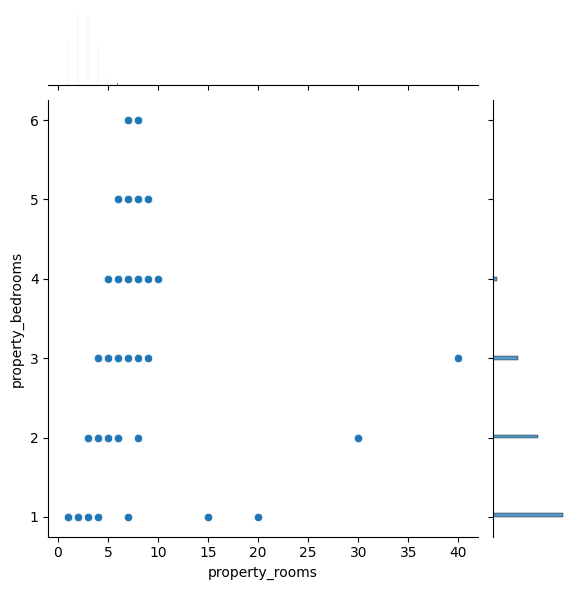

In [841]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_rooms, y= ds_filtrado.property_bedrooms)

/tmp/ipykernel_47005/1907502392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado['Mahalanobis ambientes'] = mahalanobis(ds_filtrado, ['property_rooms', 'property_surface_covered'])


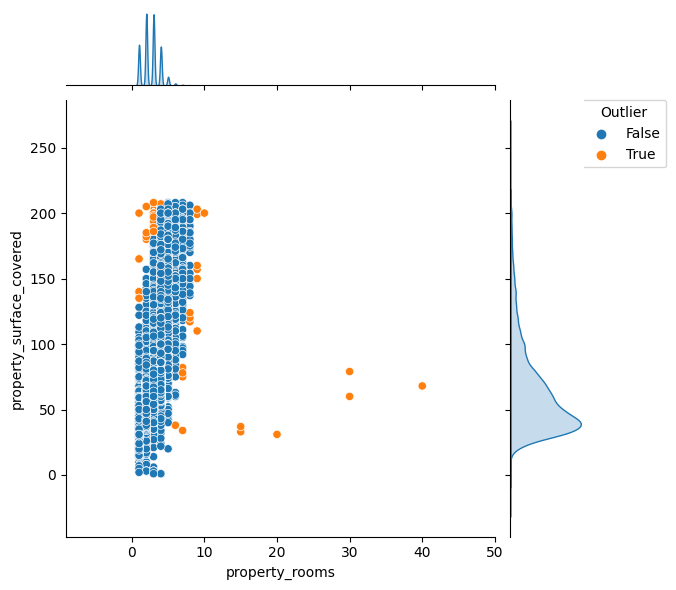

In [842]:
ds_filtrado['Mahalanobis ambientes'] = mahalanobis(ds_filtrado, ['property_rooms', 'property_surface_covered'])
radio_maximo = 30
ds_filtrado[ds_filtrado['Mahalanobis ambientes'] > radio_maximo]
es_outlier = (ds_filtrado ['Mahalanobis ambientes'] > radio_maximo)


sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_rooms, y=ds_filtrado.property_surface_covered, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0, title="Outlier")

In [843]:
ds_filtrado[ds_filtrado['Mahalanobis ambientes'] > radio_maximo]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,...,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,Mahalanobis ambientes
15346,8iv/ZBq7sL/7gmkSbf+Esw==,2021-04-22,2021-04-29,2021-04-22,-34.615603,-58.407217,Capital Federal,Balvanera,NaN,NaN,...,Venta,PH,3.0,2.0,200.0,200.0,450000.0,USD,"PH de tres ambientes con terraza en venta, in...",40.031435
15347,PIpixZZGa0NlNoH6jHs+2w==,2021-04-22,2021-04-29,2021-04-22,-34.615603,-58.407217,Capital Federal,Balvanera,NaN,NaN,...,Venta,PH,3.0,2.0,200.0,200.0,450000.0,USD,"PH de tres ambientes con terraza en venta, in...",40.031435
15898,DvyWVaERtW2kZpJFSKNJzQ==,2021-06-10,2022-02-09,2021-06-10,-34.635470,-58.363191,Capital Federal,Boca,NaN,NaN,...,Venta,PH,9.0,5.0,157.0,157.0,240000.0,USD,PH EN VENTA 4 DEPARTAMENTOS EN BLOCK EN LA BOCA,37.667730
21009,bmop3OsDu5kJmbAVgJ5wzA==,2021-03-15,2021-06-05,2021-03-15,-34.616391,-58.456038,Capital Federal,Caballito,NaN,NaN,...,Venta,Departamento,30.0,2.0,79.0,79.0,230000.0,USD,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito,1503.644830
23021,J5HJeCWwaXS4Ovk/UHPgcw==,2021-10-01,2021-11-25,2021-10-01,-34.555536,-58.438507,Capital Federal,Belgrano,NaN,NaN,...,Venta,Departamento,2.0,1.0,205.0,205.0,499000.0,USD,VENTA Depto Único con Jardín y Parrilla propia...,59.843187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439349,ZlsXJ2PCT8/p4ax5ZGmcFA==,2021-04-23,2021-04-27,2021-04-23,-34.595693,-58.397231,Capital Federal,Barrio Norte,NaN,NaN,...,Venta,Departamento,7.0,5.0,78.0,78.0,135000.0,USD,"VENTA CONSULTORIO MEDICO 5 despachos, 2 salas ...",32.983816
441866,QfTc5EXmnNiASWADoaOazA==,2021-05-07,2021-06-05,2021-05-07,-34.558517,-58.446520,Capital Federal,Nuñez,NaN,NaN,...,Venta,Departamento,1.0,1.0,160.0,135.0,450000.0,USD,Entrega inmediata! Hermosa oficina de 160m2 so...,31.144016
442353,+w2AS0W2iwlPFDeHiF3dmw==,2021-05-07,2021-06-05,2021-05-07,-34.558517,-58.446520,Capital Federal,Belgrano,NaN,NaN,...,Venta,Departamento,1.0,1.0,160.0,135.0,450000.0,USD,Entrega inmediata! Hermosa oficina de 160m2 so...,31.144016
453847,NTZQ7bMIl4KrSNE/Yna15A==,2021-12-16,2022-02-09,2021-12-16,-34.635489,-58.502057,Capital Federal,Villa Luro,NaN,NaN,...,Venta,Casa,10.0,4.0,200.0,200.0,224000.0,USD,¡Venta Única! Casa en Villa Luro Patio y Terraza,43.554481


In [844]:
ds_filtrado.drop('Mahalanobis ambientes', axis=1, inplace=True)

/tmp/ipykernel_47005/822538010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado.drop('Mahalanobis ambientes', axis=1, inplace=True)


Todas parecen legítmas viendo las descripciones, por lo que no hay que modificar los datos.

### Relación entre precio y superficie

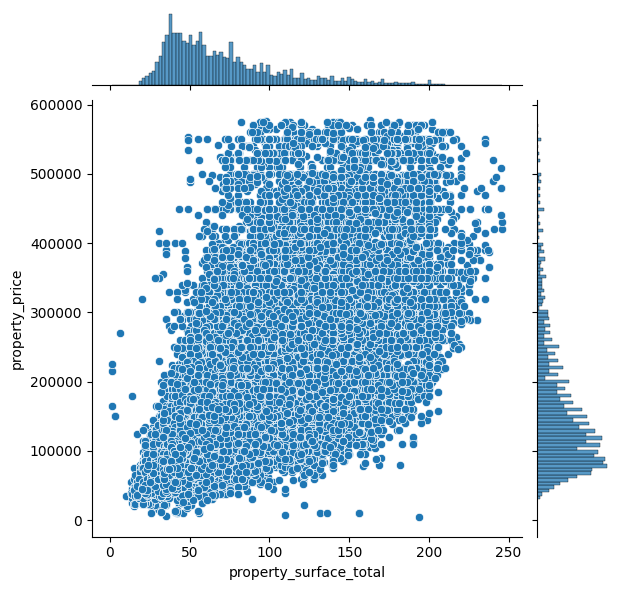

In [845]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_surface_total, y=ds_filtrado.property_price)

/tmp/ipykernel_47005/4115738287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_filtrado['Mahalanobis'] = mahalanobis(ds_filtrado,['property_surface_total', 'property_price', 'latitud', 'longitud'])


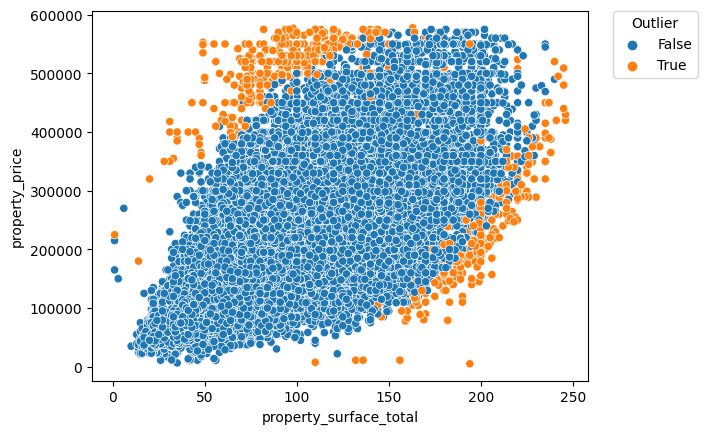

In [846]:
ds_filtrado['Mahalanobis'] = mahalanobis(ds_filtrado,['property_surface_total', 'property_price', 'latitud', 'longitud'])
radio_maximo = 20
ds_filtrado[ds_filtrado['Mahalanobis'] > radio_maximo]
es_outlier = (ds_filtrado['Mahalanobis'] > radio_maximo)

sns.scatterplot(x=ds_filtrado.property_surface_total, y=ds_filtrado.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")

In [847]:
ds_filtrado[ds_filtrado['Mahalanobis'] > radio_maximo]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,...,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,Mahalanobis
1233,1AXI3W1wc1zyMireeV8MOg==,2021-09-09,2021-11-22 10:42:07.845036320,2021-09-09,-34.573180,-58.486896,Capital Federal,Villa Urquiza,NaN,NaN,...,Venta,Departamento,5.0,3.0,20.0,20.0,320000.0,USD,Departamento venta,21.604492
1510,jux+UAgqe9y/GdR+NDl9oQ==,2021-12-17,2022-02-09 00:00:00.000000000,2021-12-17,-34.575905,-58.489325,Capital Federal,Villa Urquiza,NaN,NaN,...,Venta,PH,4.0,2.0,228.0,163.0,349000.0,USD,Venta PH 4 ambiente Villa Urquiza Terraza Quincho,22.405854
2818,OeSK9lyp1Yn4TS8NyAIscw==,2021-12-17,2022-02-09 00:00:00.000000000,2021-12-17,-34.595795,-58.502680,Capital Federal,Villa Devoto,NaN,NaN,...,Venta,Departamento,4.0,3.0,106.0,106.0,515000.0,USD,VENTA SEMIPISO 4 AMB EN DEVOTO C/ BALCÓN Y COC...,28.836641
3029,Rzs6g+rb6/MBCGMM1TAO1A==,2021-02-20,2021-03-01 00:00:00.000000000,2021-02-20,-34.647586,-58.382099,Capital Federal,Barracas,NaN,NaN,...,Venta,PH,4.0,3.0,159.0,159.0,78000.0,USD,OPORTUNIDAD PH A RECICLAR!!!,24.895671
3305,+IsteH80pARElmilyhBoBg==,2021-02-20,2021-04-20 00:00:00.000000000,2021-02-20,-34.609695,-58.527710,Capital Federal,Villa Devoto,NaN,NaN,...,Venta,Casa,5.0,3.0,226.0,162.0,450000.0,USD,Casa - Villa Devoto,20.732978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458963,siIDwwEibfXCI1DyxzlxTg==,2021-01-05,2021-07-19 00:00:00.000000000,2021-01-05,-34.649214,-58.486184,Capital Federal,Parque Avellaneda,NaN,NaN,...,Venta,Casa,6.0,5.0,195.0,195.0,210000.0,USD,VENTA CASA 5 AMBIENTES - GARAGE - PATIO - QUIN...,20.231352
459406,cxce8s7ZUpaH6NLzWuyXyA==,2021-01-05,2021-06-05 00:00:00.000000000,2021-01-05,-34.582207,-58.405338,Capital Federal,Palermo,NaN,NaN,...,Venta,Departamento,5.0,3.0,148.0,148.0,570000.0,USD,Excelente duplex en VENTA en Palermo Chico en ...,20.074069
459756,gelwV/1eUr7wLDxrSQmUSg==,2021-01-05,2022-06-11 00:00:00.000000000,2021-01-05,-34.591895,-58.386301,Capital Federal,Recoleta,NaN,NaN,...,Venta,Departamento,4.0,2.0,80.0,80.0,460000.0,USD,Loft de 3 dormitorios en venta en lo mejor de...,20.605723
460002,w+3qsITCAFukJ0S15B8znQ==,2021-01-05,2021-07-07 00:00:00.000000000,2021-01-05,-34.618595,-58.361978,Capital Federal,Puerto Madero,NaN,NaN,...,Venta,Departamento,2.0,1.0,56.0,56.0,520000.0,USD,Excelente Suite en Hotel SLS Puerto Madero | 2...,45.159737


In [848]:
ds_filtrado = ds_filtrado[ds_filtrado['Mahalanobis'] <= radio_maximo]

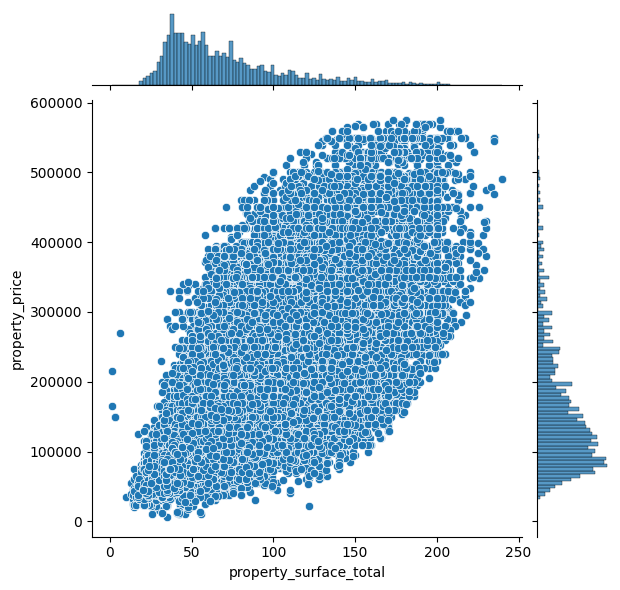

In [849]:
sns.jointplot(data=ds_filtrado,x= ds_filtrado.property_surface_total, y=ds_filtrado.property_price)